In [1]:
## Cell required to run other cells in the file
## Note in this script IKP files are outdated
%pylab inline
import pandas as pd
import xarray as xr
import glob, re, os
import scipy
import pickle
import sz
from IPython.core.debugger import Tracer

import traceback
import warnings
import sys
# warnings.filterwarnings('error')

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    traceback.print_stack()
    log = file if hasattr(file,'write') else sys.stderr
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
## uncomment the following line to have detailed warning info
# warnings.showwarning = warn_with_traceback

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'Bitstream Vera Sans','sans-serif':['Helvetica']})


def loadRastaflt(szi):
    datapath='/data/mcfarq/a/szhu28/research/HIWC/data/fulldataDarwin/RASTA/data/'
    rastafn=glob.glob(datapath+'*_F'+str(szi)+'_*.nc')
    return xr.open_dataset(rastafn[0])

## Easy function to sub-setting data based on iwc, temperature, mmd based on dataf
def subsetdata(tempr=[-inf,inf], iwcr=[-inf,inf], mmdr=[-inf,inf],msd=False):

    tmpind = (dataf['temp']>tempr[0]) & (dataf['temp']<tempr[1])
    tmpind = tmpind & (dataf['iwc']>iwcr[0]) & (dataf['iwc']<iwcr[1])
    # tmpind = (dataf['temp']>-37.5) & (dataf['temp']<-32.5)
    # tmpind = tmpind & (dataf['iwc']<5) & (dataf['iwc']>2.5)
    tmpind = tmpind & (dataf['mmd']>mmdr[0]) & (dataf['mmd']<mmdr[1])
    tmpdataf = dataf[tmpind]
    
    tmpindrawvar = tmpdataf['indpsdforward']
    tmpindrawvar = tmpindrawvar[~isnan(tmpindrawvar)].astype(int)
    
    tmpindrawvar = rawpsd['indpsdbackward'][tmpindrawvar]

    indlvl1 = ~isnan(tmpdataf['indpsdforward'])
    a = tmpdataf['indpsdforward'][indlvl1]
    nonpsd = tmpdataf[indlvl1]
    if msd==False:
        psd = rawpsd['psddmax'].iloc[ a.astype(int),: ]
    else:
        psd = rawpsd['msddmax'].iloc[ a.astype(int),: ]
    ## Use rawvar.iloc[tmpindrawvar] for data access
    return nonpsd,psd, tmpindrawvar

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as sio    # For .mat version before 7.3
import h5py    # For .mat version after 7.3
import pandas as pd
matlabpath='/data/mcfarq/a/szhu28/research/HIWC/10_150901Wholeflight/src/analysis/example/data/'
filenames=np.array(['processed.mat','rawFIT.mat','rawPSD.mat','rawVAR.mat'])
'''
for szi in range(4):
    tmpfn=matlabpath+filenames[szi]
    try:
        raw=h5py.File(tmpfn,'r')
#         print('hdf '+str(szi))
        raw.close()
    except:
        raw=sio.loadmat(tmpfn)
#         raw=sio.whosmat(tmpfn)
#         varnames=raw.items()
'''
raw=sio.loadmat(matlabpath+filenames[3])
proc=sio.loadmat(matlabpath+filenames[0])
proc['indpsdforward']-=1                     ############ PYTHON VS MATLAB
proc['indpsdback']-=1

### 5 seconds running mean of iwc
tmpiwc=pd.DataFrame(raw['TWCIKPZRgm3'].ravel())
iwc_mean=tmpiwc.rolling(window=5,center=True,min_periods=3).mean().as_matrix()

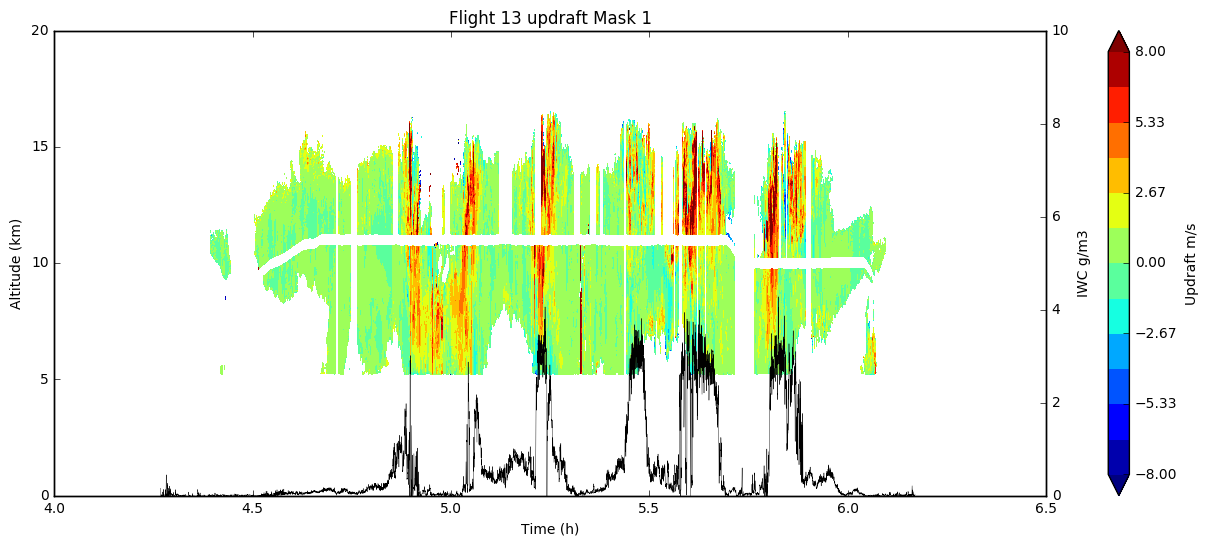

In [3]:
ds = loadRastaflt(13)
tmp=ds['w_ret']
# tmp=tmp.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
tmp=tmp.where((ds.Mask_Vz==1))
# thresh=14
# tmp=tmp.where((tmp<thresh) & (tmp>-thresh))
tmp=tmp.transpose()
fig=plt.figure(figsize=[16,6])    ########### comment me
plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
             tmp,np.linspace(-8,8,13),extend='both')
ax=plt.gca()
hcb=plt.colorbar()
hcb.set_label('Updraft m/s')
plt.ylim(0,20)
plt.xlabel('Time (h)')
plt.ylabel('Altitude (km)')
plt.title('Flight 13 updraft Mask 1')
ax2=ax.twinx()
indflt=(raw['flightnum']==13)
iwc=raw['TWCIKPZRgm3'][indflt]
time=raw['Time'][indflt]
ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
ax2.set_ylim(0,10)
_=ax2.set_ylabel('IWC g/m3')

### Updraft in flight 13 from RASTA.
In RASTA there're two types of masks. One called Mask in the above figures is for the Vz component, where 1 stands for good confidence, 2 for should not be used, 3 for could be used but carefully. The second system of masks is denoted as Phs Mk in the following figures indicates the Attenuation and Phase flag, where meaning of each flag is written in the figures. All plots are overlaid with IWC curve to indicate the time when in cloud or not.

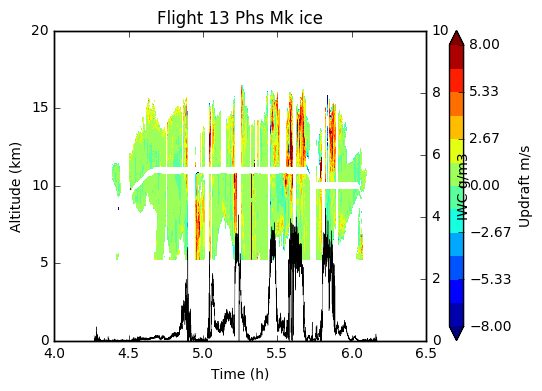

/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


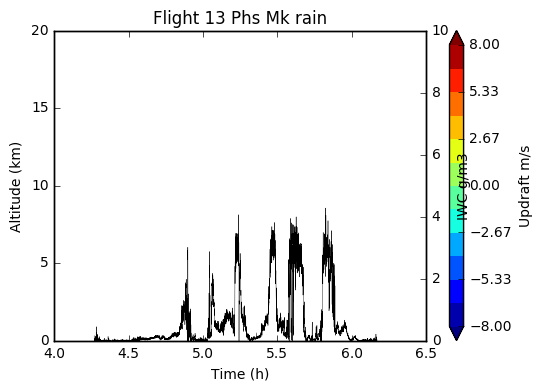

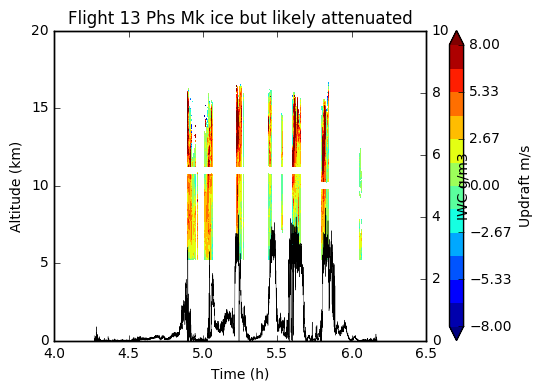

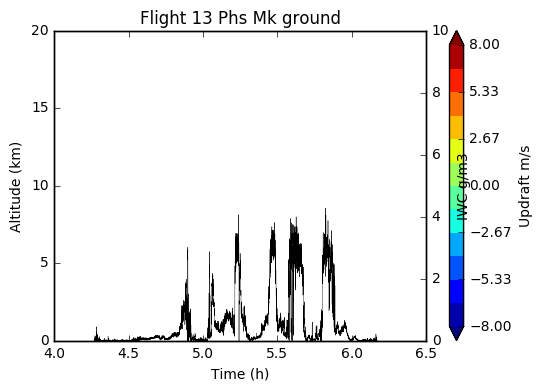

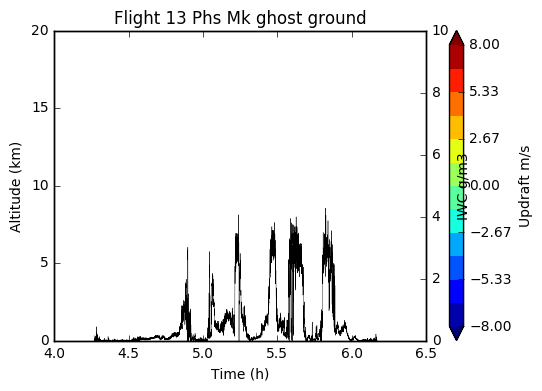

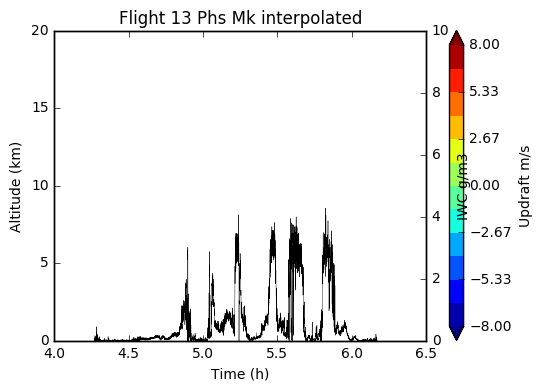

In [4]:
attmk=np.array(['no cloud','ice','rain','ice but likely attenuated','ground','ghost ground','interpolated'])
szi=13
for j in range(6):
    szj=j+1
    ds = loadRastaflt(szi)
    tmp=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
    tmp=tmp.where(ds.attenuation_phase_flag==szj)
    # tmp=tmp.where((ds.Mask_Vz==1))
    # thresh=14
    # tmp=tmp.where((tmp<thresh) & (tmp>-thresh))
    tmp=tmp.transpose()
    #fig=plt.figure(figsize=[16,6])    ########### comment me
    plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
                 tmp,np.linspace(-8,8,13),extend='both')
    ax=plt.gca()
    hcb=plt.colorbar()
    hcb.set_label('Updraft m/s')
    plt.ylim(0,20)
    plt.xlabel('Time (h)')
    plt.ylabel('Altitude (km)')
    plt.title('Flight '+str(szi)+' Phs Mk '+str(attmk[szj]))
    ax2=ax.twinx()
    indflt=(raw['flightnum']==szi)
    iwc=raw['TWCIKPZRgm3'][indflt]
    time=raw['Time'][indflt]
    ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
    ax2.set_ylim(0,10)
    ax2.set_ylabel('IWC g/m3')
    plt.show()

Gate    [245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
Points [4402   19   18    0    0    0    0    1    1 4302]


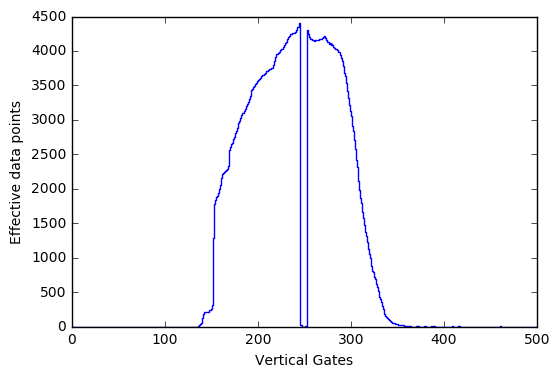

In [5]:
tmp=(~np.isnan(ds['w_ret'].values)).sum(axis=0)
plt.step(range(len(tmp)),tmp)
plt.xlabel('Vertical Gates')
plt.ylabel('Effective data points')
print('Gate    '+str(range(245,255)))
print('Points '+str(tmp[245:255]))

### Vz near flight track
Vz is the vertical component of the retrieved 3-D winds from RASTA. There are 500 vertical gates in all and the aircraft is between gate 249 and 250. The figure above indicates there are very few efficient data 3 gates within the aircraft.

The following figure shows the gates altitude with respect to the gate 249. It's still not clear why the relative range is not constant throughout time. It's now clear that the roll angle is causing the actual altitude change of the gates.

In [6]:
print('Distance between gates is '+str(np.average(np.diff(ds.range)))+' km')

Distance between gates is 0.06 km


The RASTA dataset actually contain part of the latest V5 SAFFIRE data and it reminds me that the SAFFIRE data I'm currently using (V3) is outdated. The below linear regressions shows the SAFFIRE updraft comparison between V5 and V3 in each flight. Most of them OK, some flight has large deviation.

The updraft at the aircraft location are derived from RASTA by computing the average of the closest effective gates above and below the aircraft, i.e. gate 245 and 254.

The correlation between updraft from RASTA retrieved and the SAFFIRE (upper figure V3, lower figure V5) is displayed. Both of them show a low correlation coefficient and the RASTA tends to be underestimating strong updrafts.

Rsquare 0.470502803785
Slope 0.869966761333
Intercept -0.113003322405


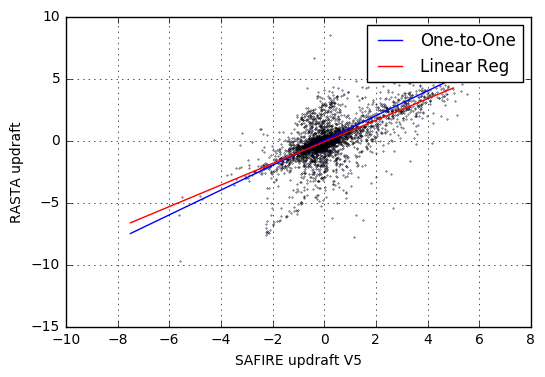

In [7]:
ds = loadRastaflt(13)

w1=ds.w_wind.values
w2=np.mean( ds.w_ret.values[:,np.array([245,254])], axis=1)

from scipy import stats
plt.scatter(w1,w2,s=.1)
o2o=np.array(plt.gca().get_ylim())*0.5
plt.plot(o2o,o2o,'b')
plt.grid(b=True)
mask = ~np.isnan(w1) & ~np.isnan(w2)
slope, intercept, r_value, p_value, std_err = stats.linregress(w1[mask],w2[mask] )
plt.plot(o2o,o2o*slope+intercept,'r')
plt.xlabel('SAFIRE updraft V5')
plt.ylabel('RASTA updraft')
print('Rsquare '+str(r_value**2))
print('Slope '+str(slope))
print('Intercept '+str(intercept))
plt.legend(['One-to-One','Linear Reg']);

## IMPORTANT
Below are comparisons of vertical updraft profiles between flight 13 (double mode PSD case) and flight 16 (single mode PSD case). We shall discuss this figure sometime as I don't have much experience in interpreting radar images. But for now some things I could think of are

1. Why could there be vertically inconsistent updraft profile? This might mean the convection initiated from the mid-level rather than from the sea surface.
2. ***Flight 16 has higher updraft below the aircraft,*** which, in the back-tracking sense, indicates the ice particles in the aircraft level are of younger age (since they're lifted fast and do not lay over in the layer). This could partly explain why the PSD tends to be single moded in flight 16 because there's not enough time for aggregation, i.e., formation of a second mode.

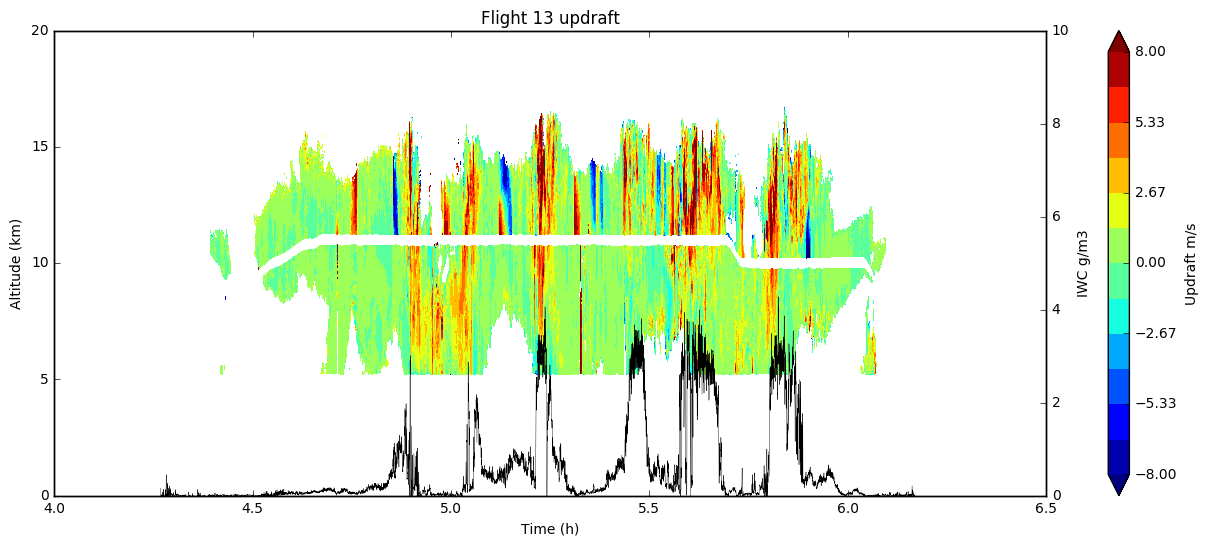

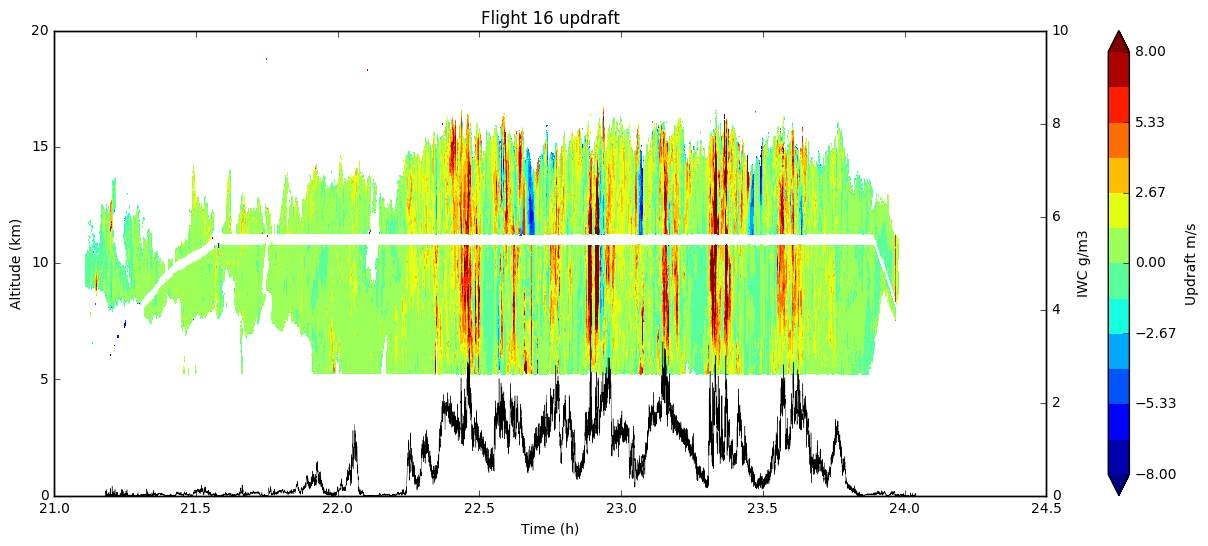

In [8]:
for i in [12,15]:
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        ds = loadRastaflt(szi)
        tmp=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        #tmp=tmp.where((ds.attenuation_phase_flag==1) | (ds.attenuation_phase_flag==3))
        # tmp=tmp.where((ds.Mask_Vz==1))
        tmp=tmp.transpose()
        plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
                     tmp,np.linspace(-8,8,13),extend='both')
        ax=plt.gca()
        hcb=plt.colorbar()
        hcb.set_label('Updraft m/s')
        plt.ylim(0,20)
        plt.xlabel('Time (h)')
        plt.ylabel('Altitude (km)')
        plt.title('Flight '+str(szi)+' updraft')
        ax2=ax.twinx()
        indflt=(raw['flightnum']==szi)
        iwc=raw['TWCIKPZRgm3'][indflt]
        time=raw['Time'][indflt]
        ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
        ax2.set_ylim(0,10)
        ax2.set_ylabel('IWC g/m3')
        plt.show()
    except:
        pass

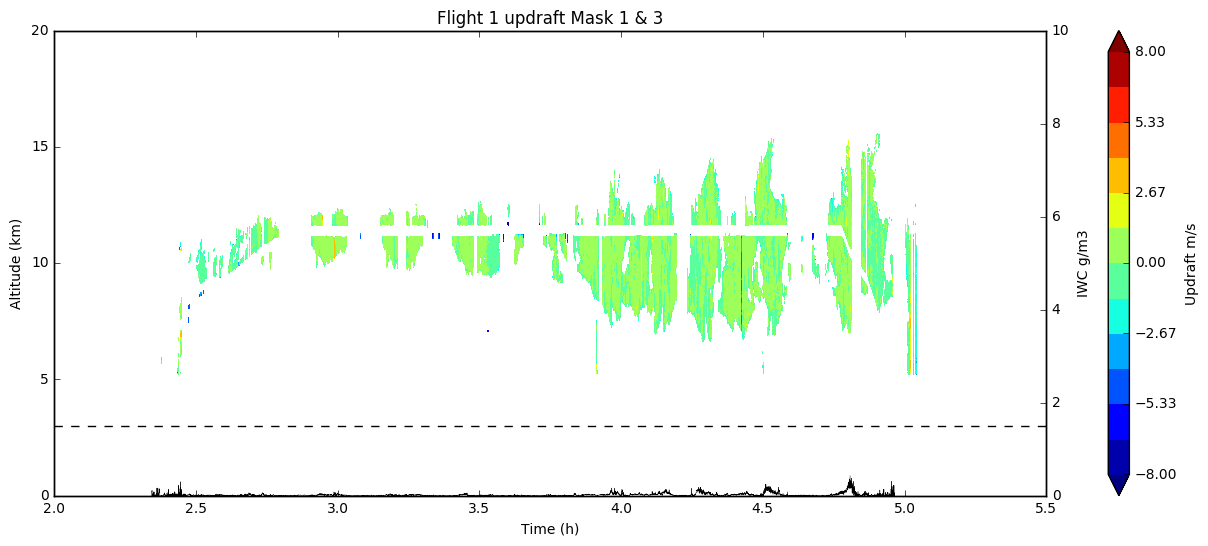

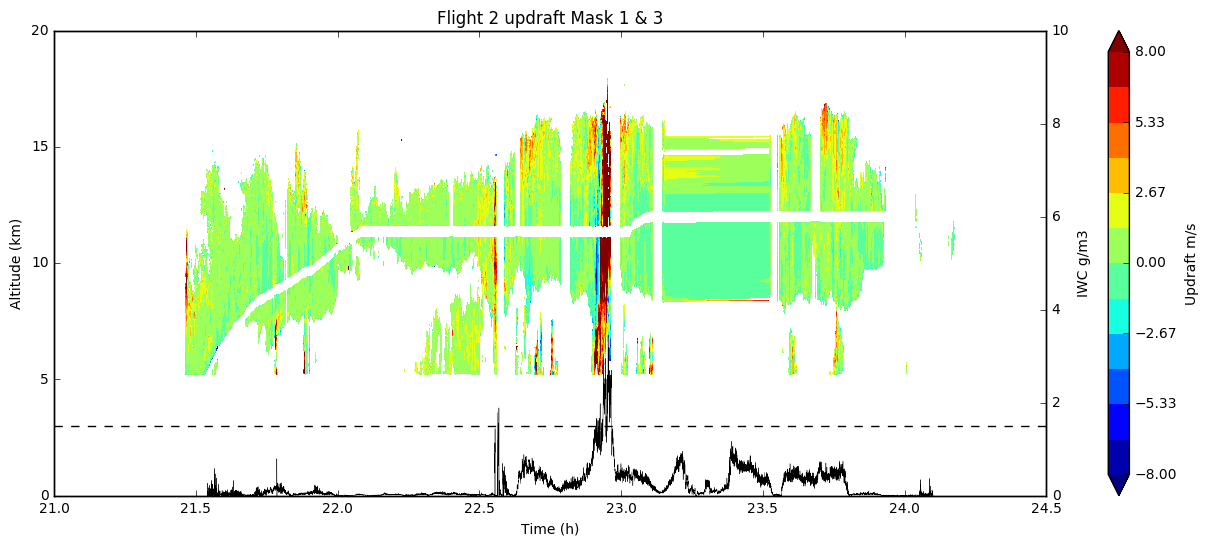

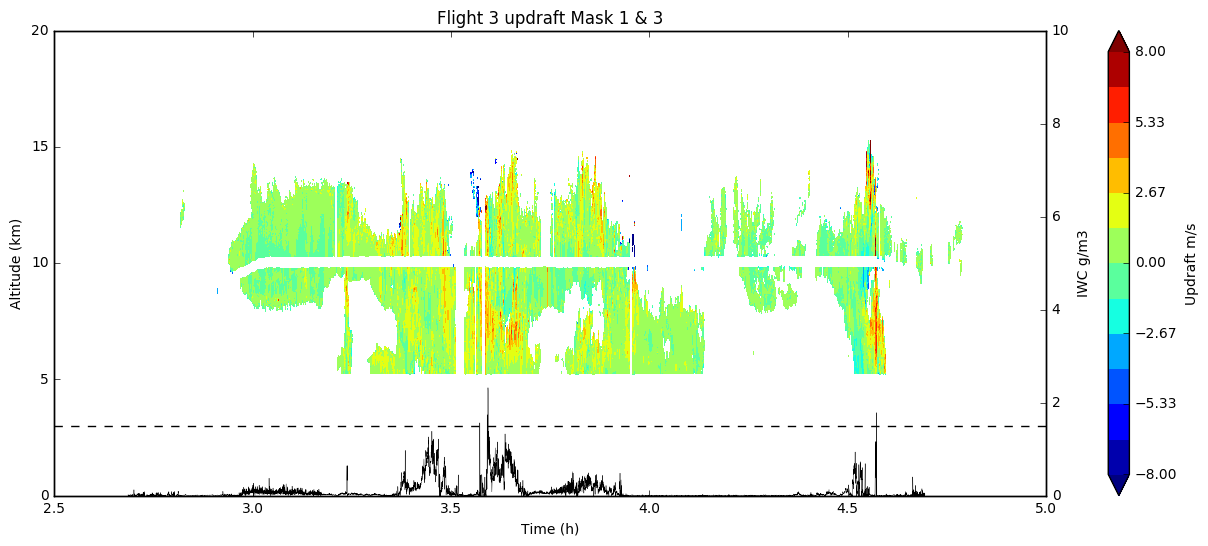

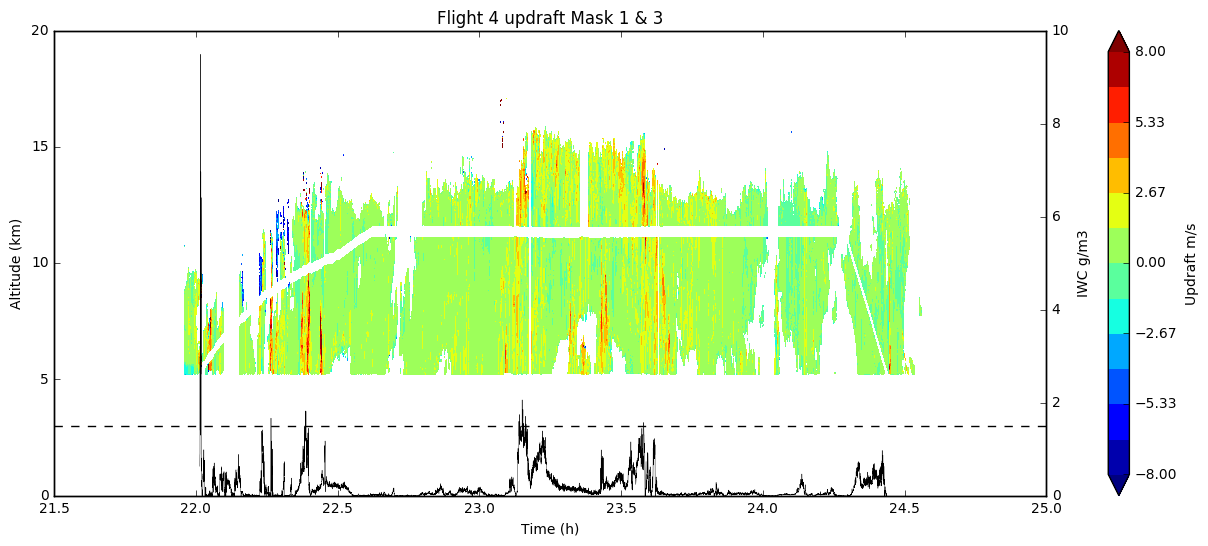

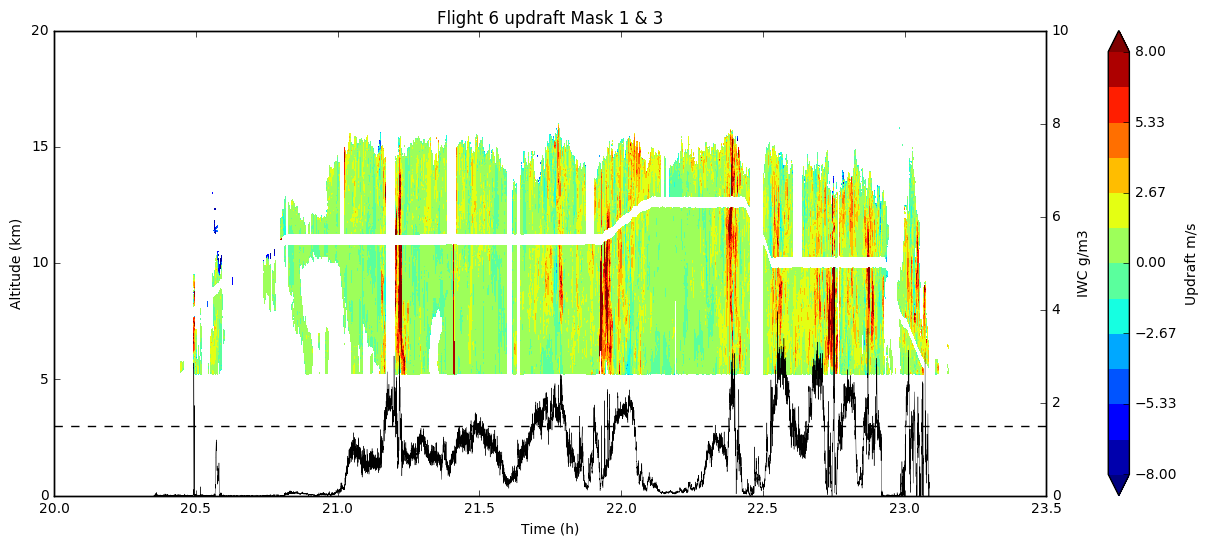

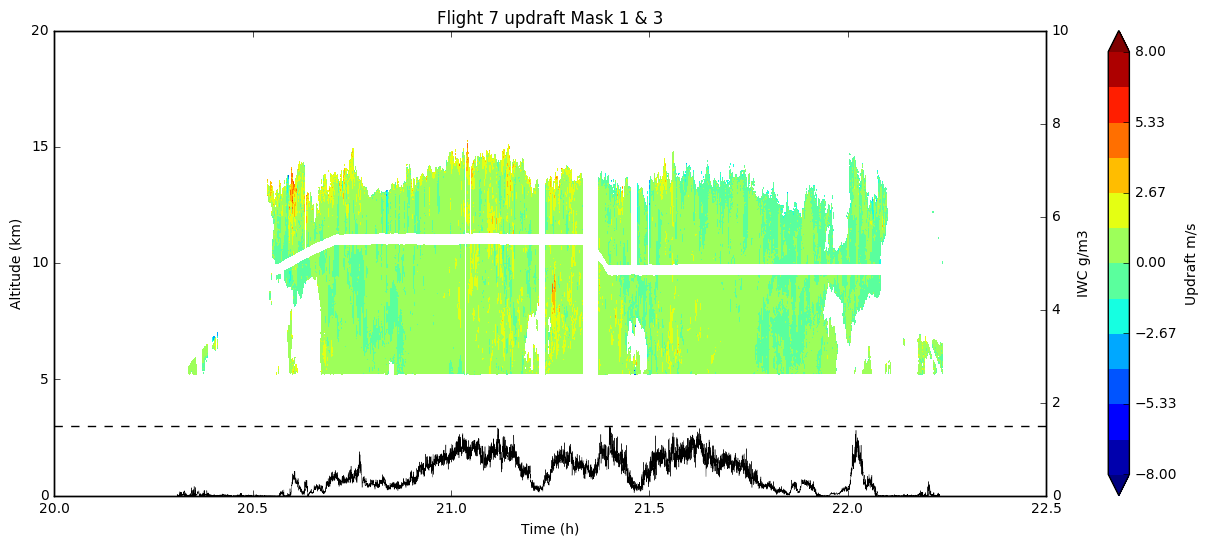

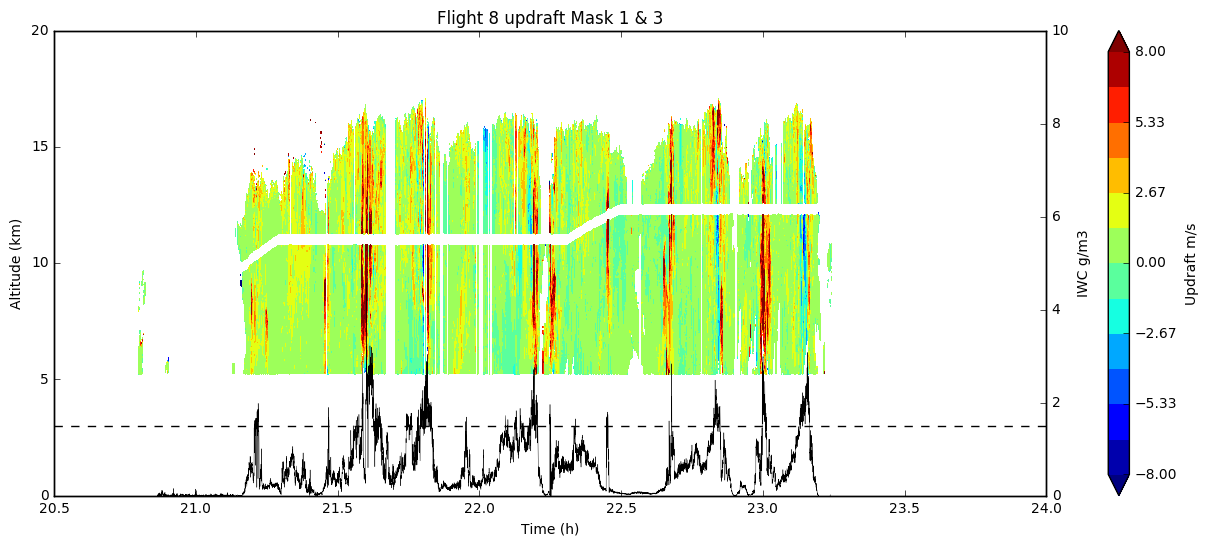

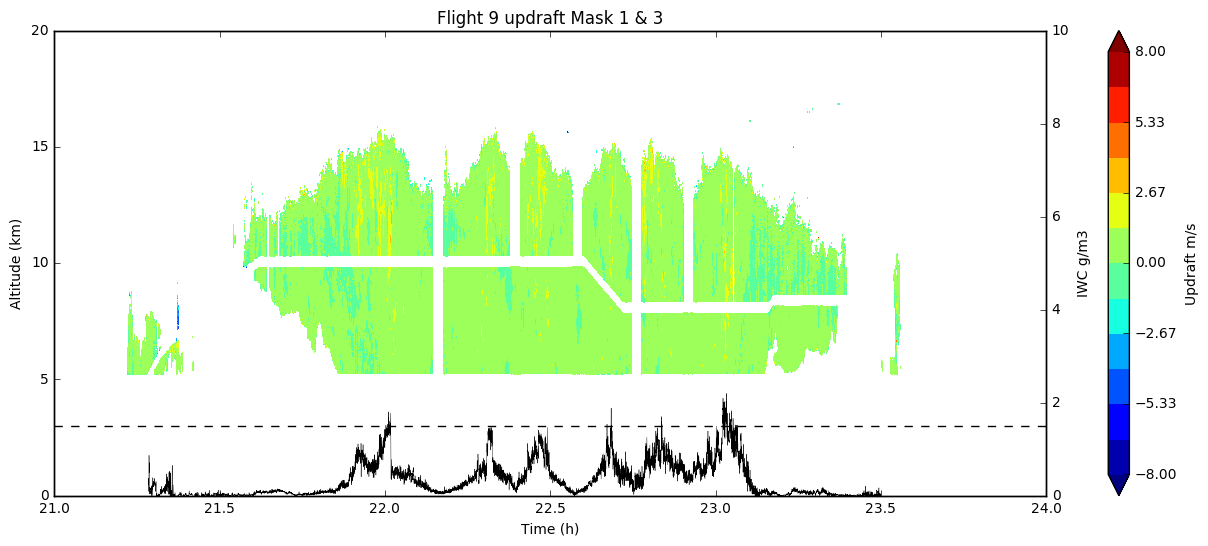

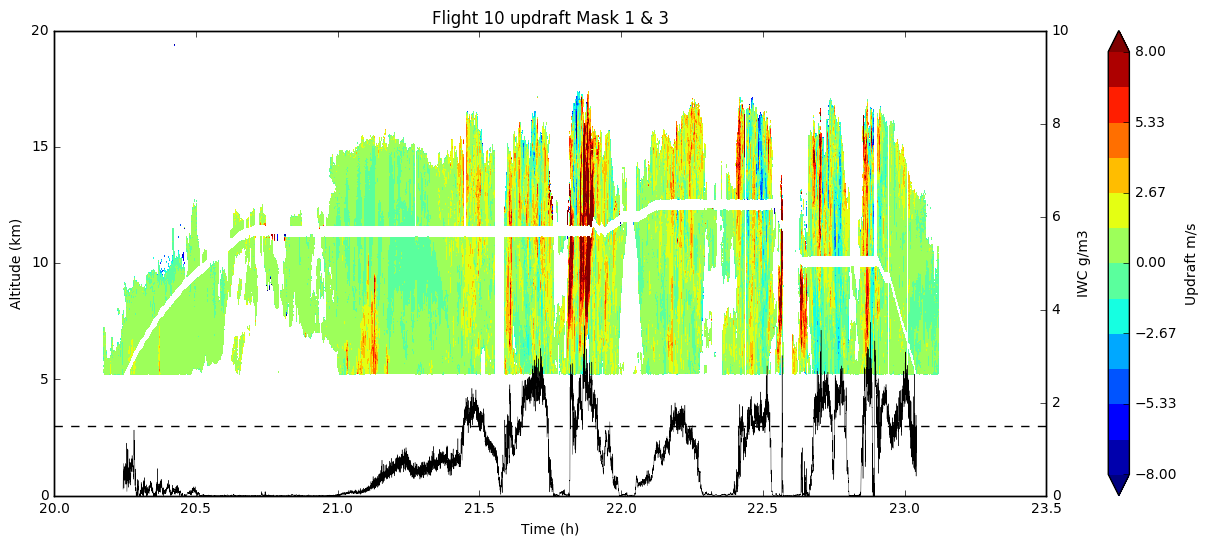

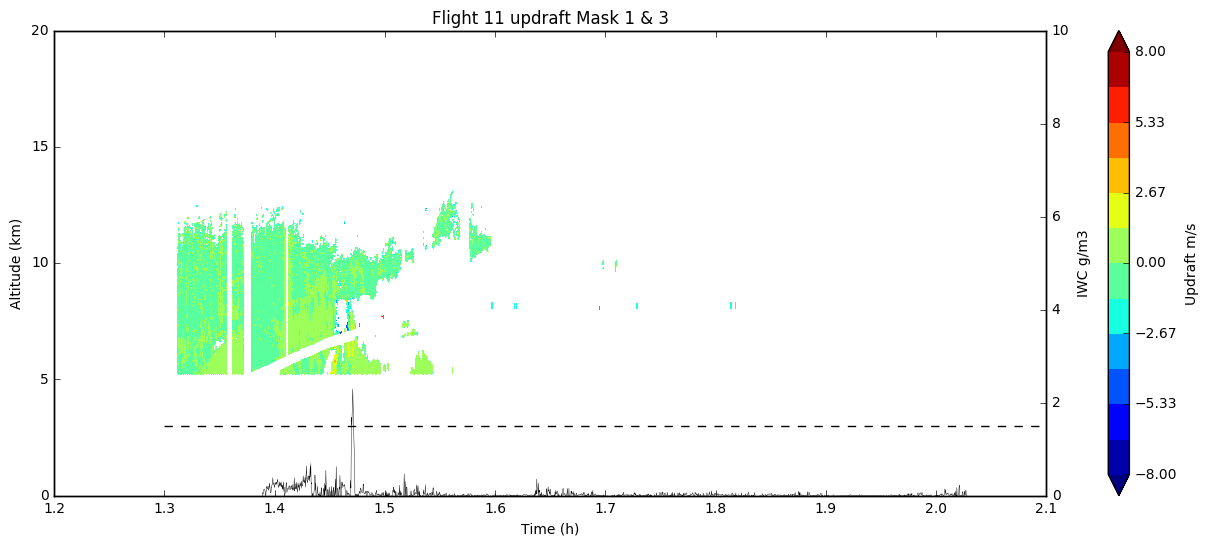

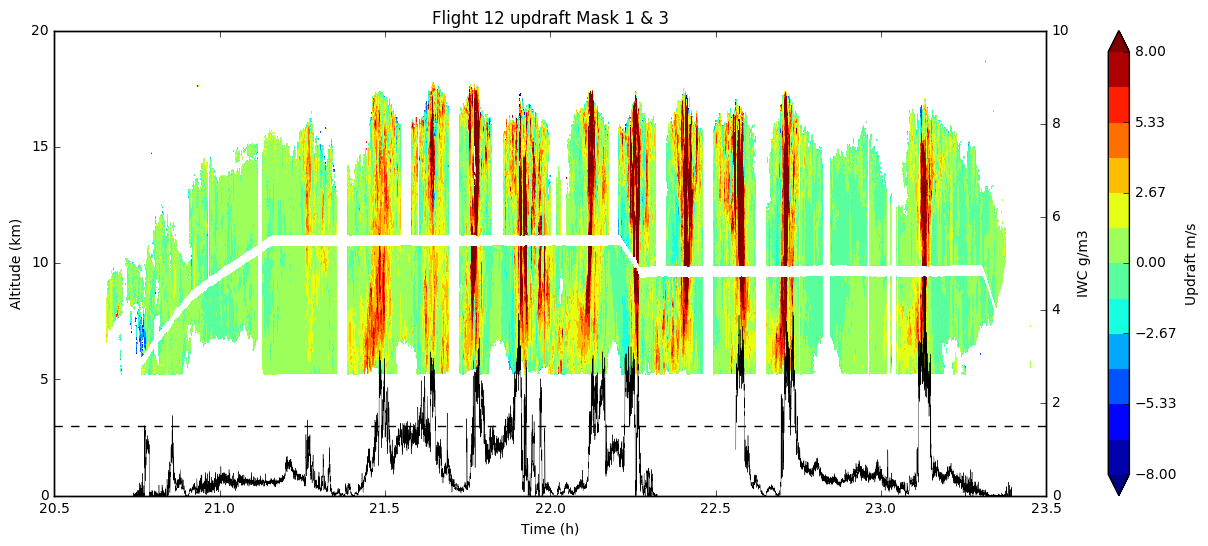

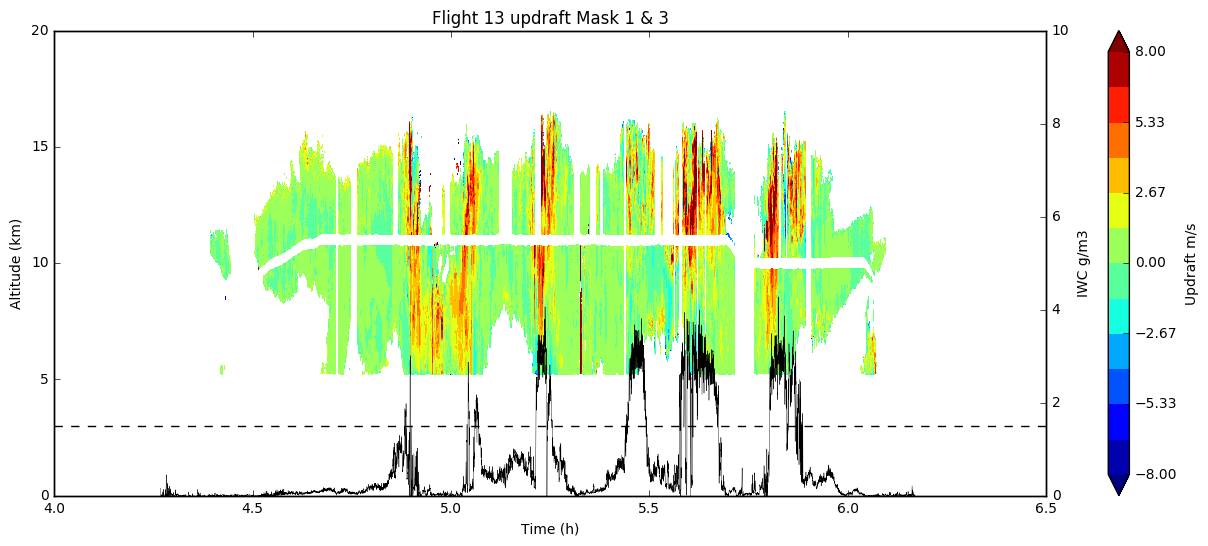

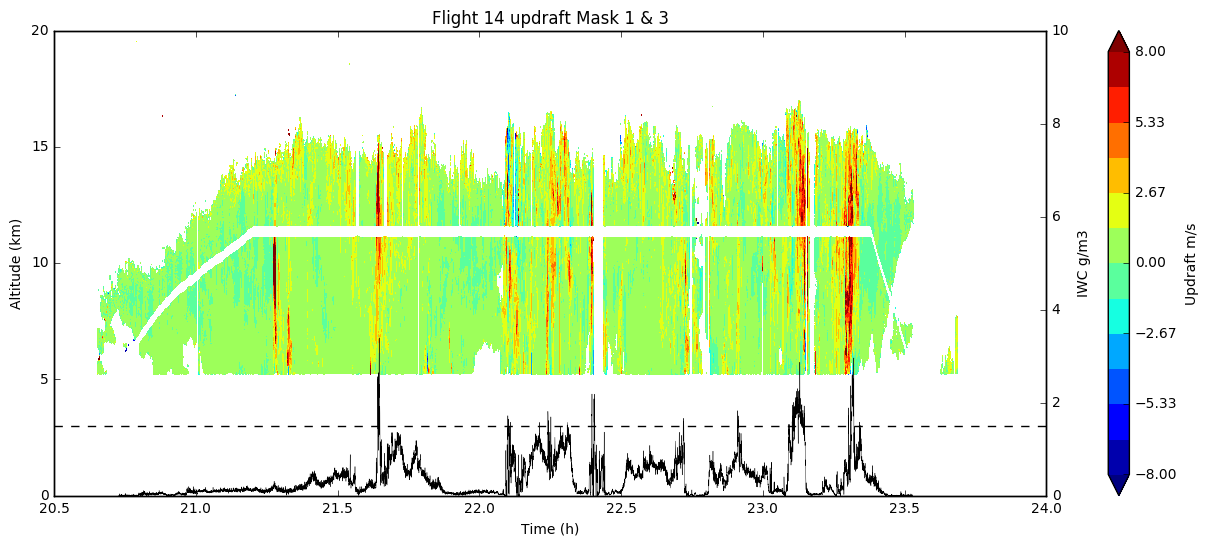

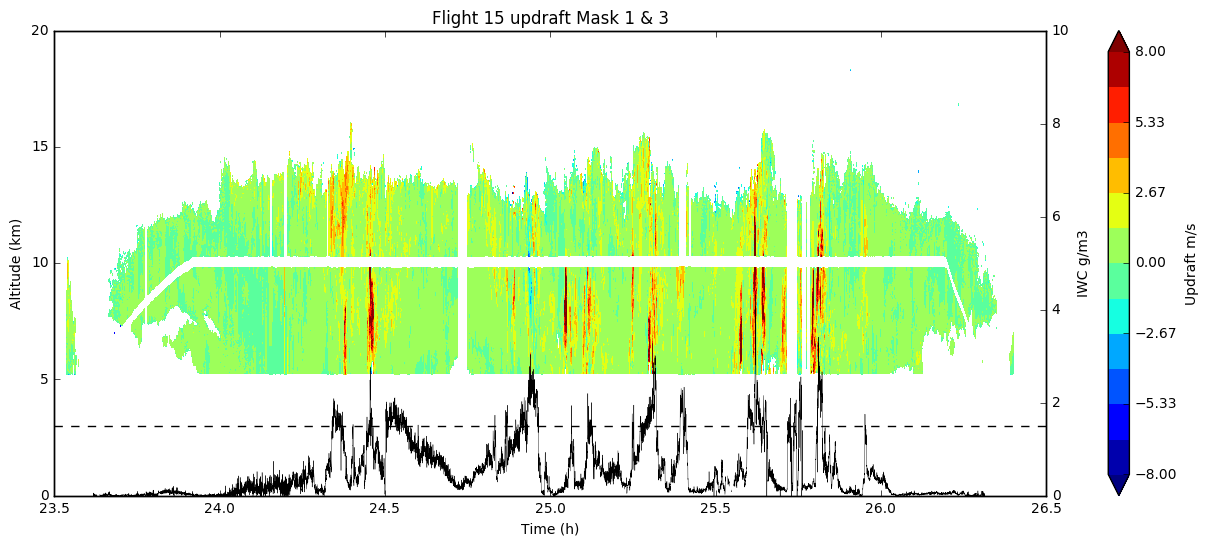

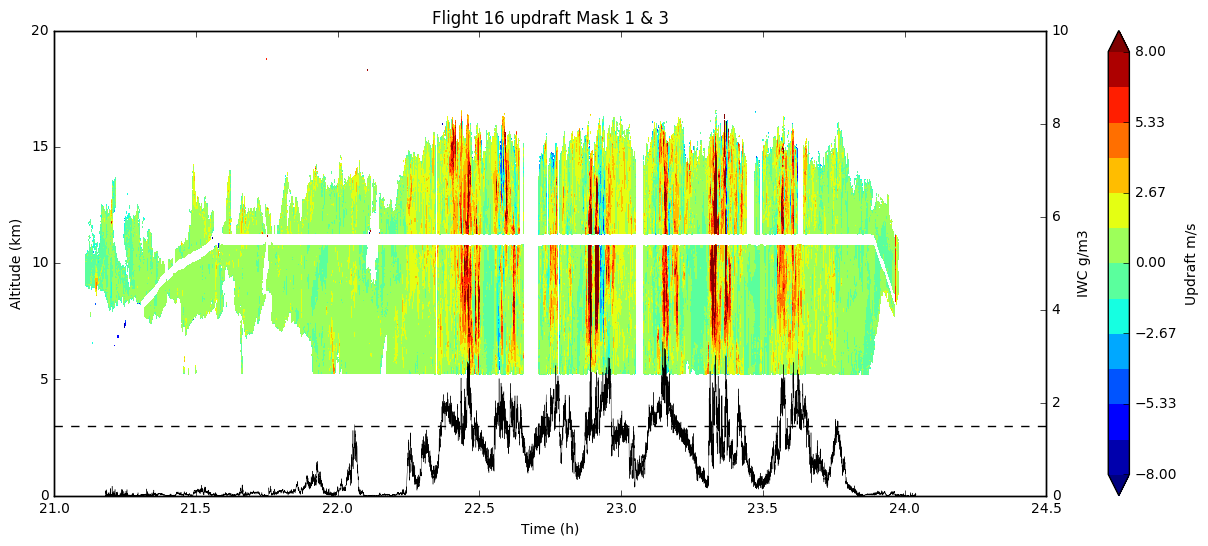

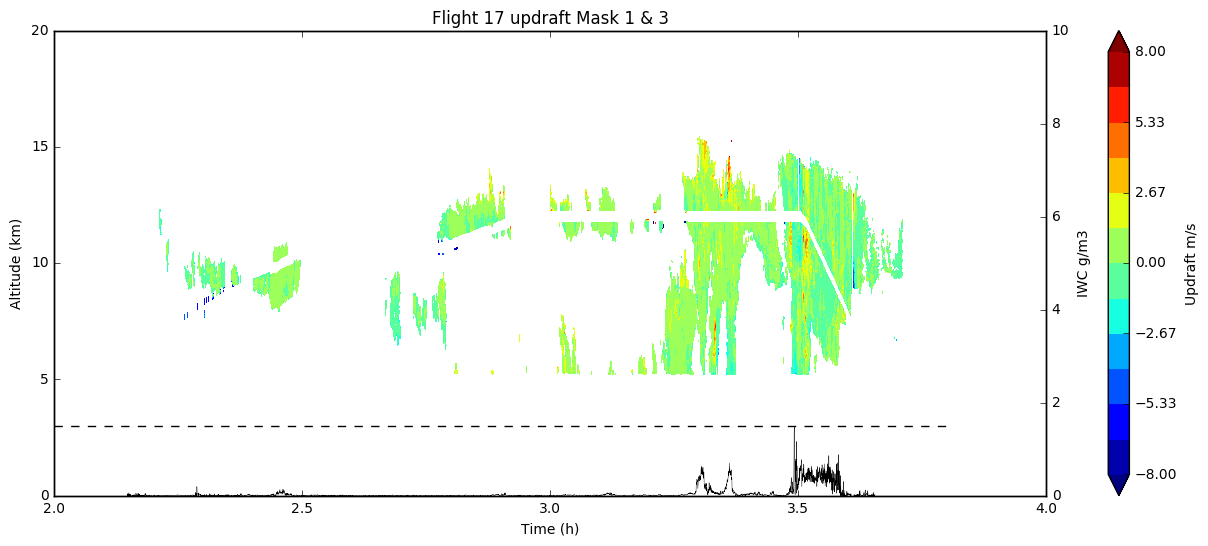

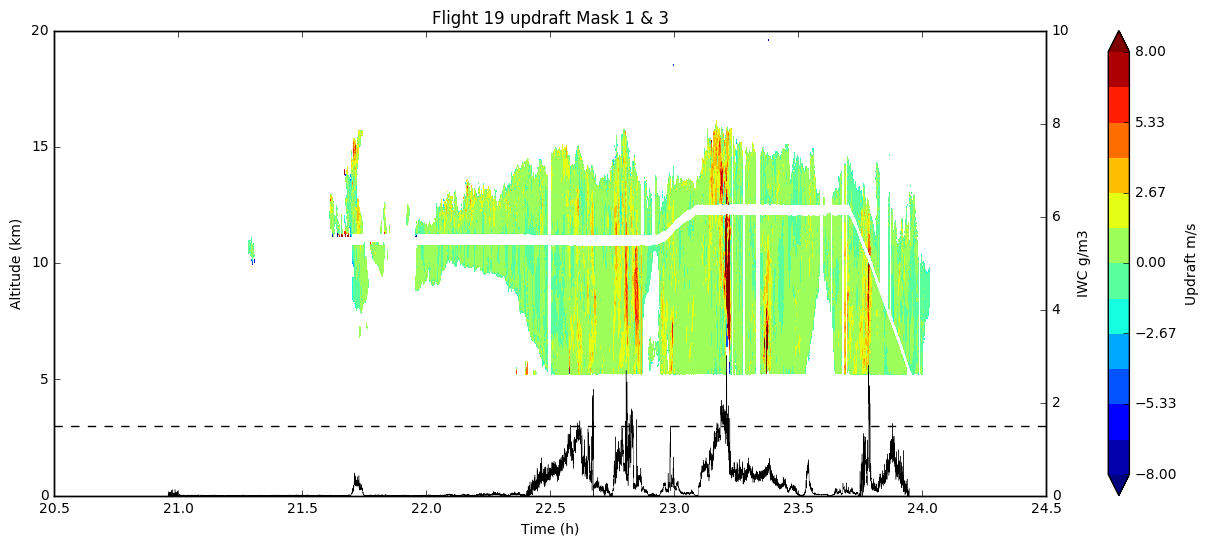

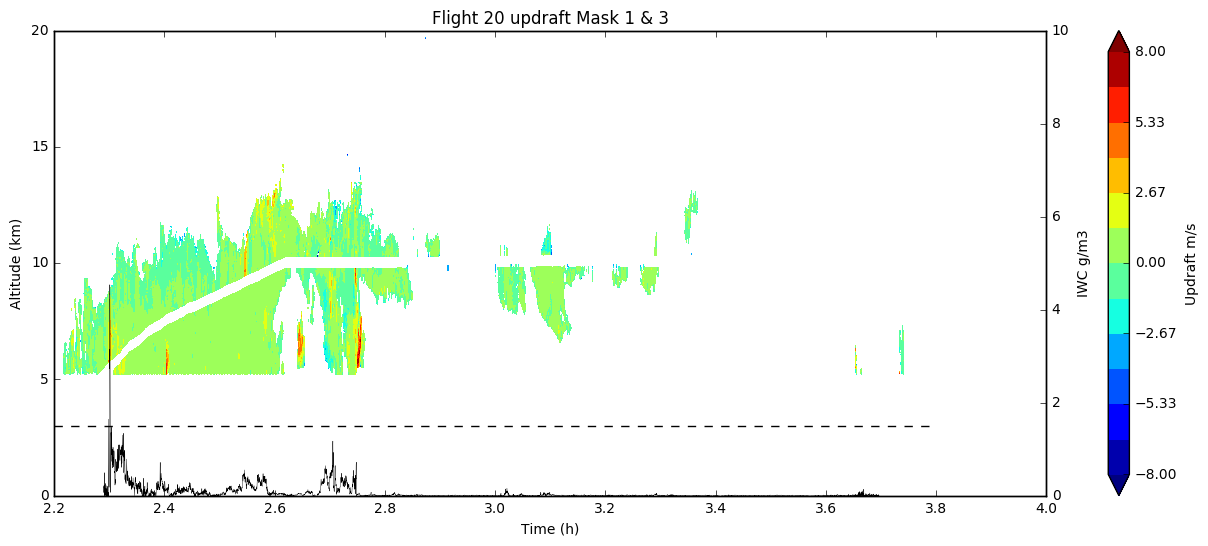

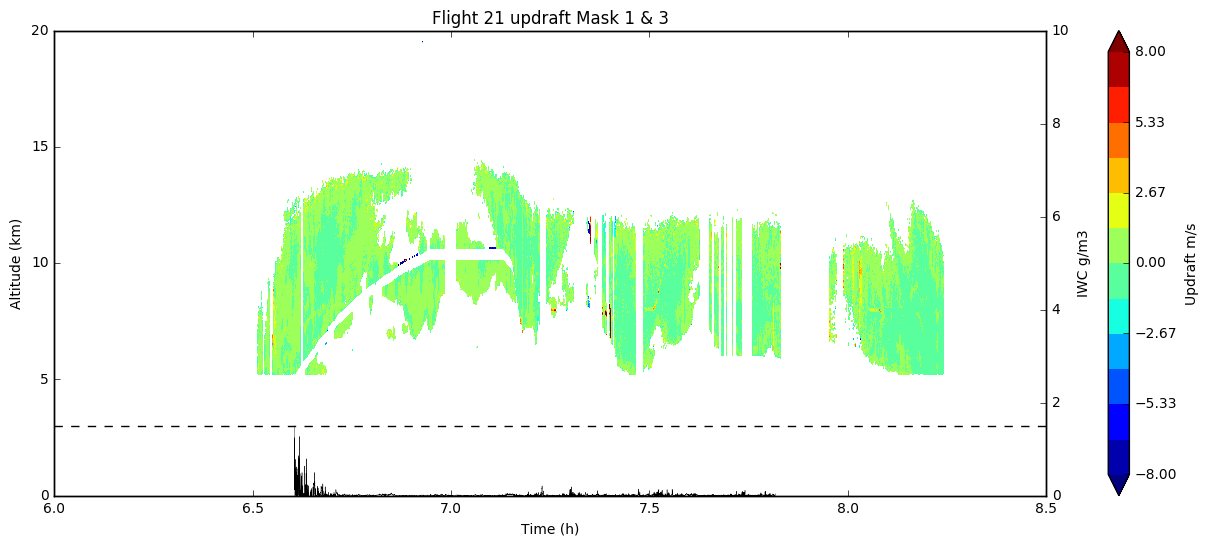

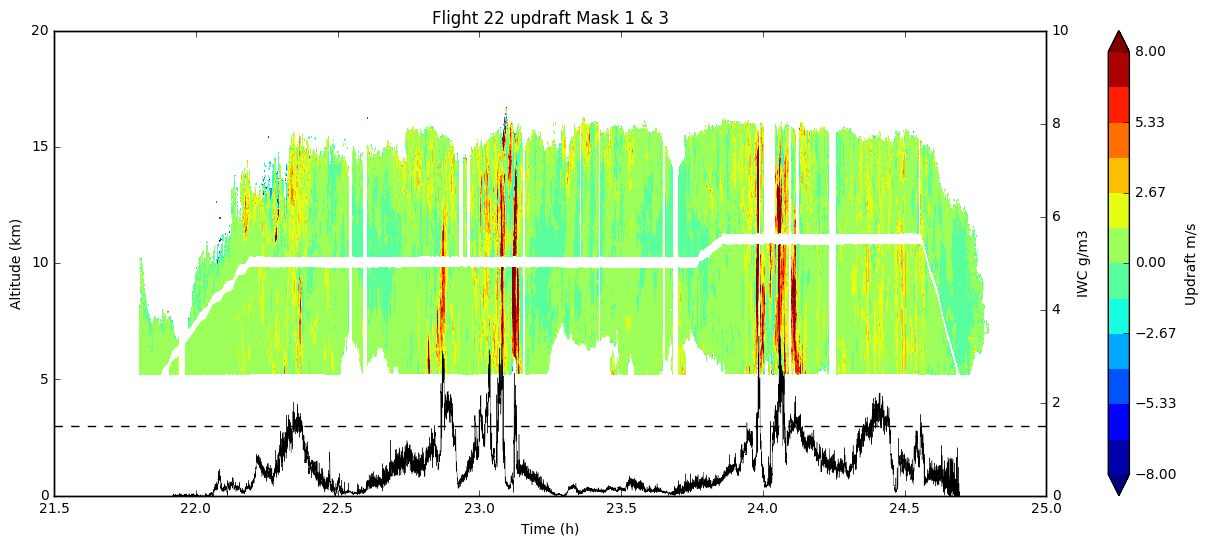

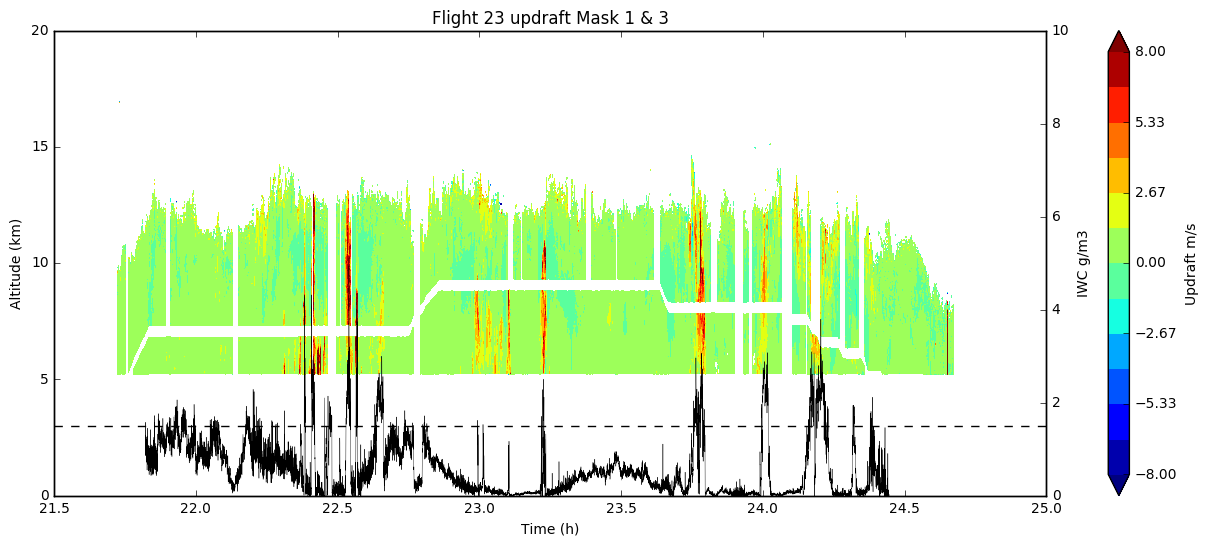

In [9]:
## vertical updraft profile through time
totaln=23
for i in range(totaln):
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        ds = loadRastaflt(szi)
#         tmp=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        tmp=ds.w_ret.where(ds.Mask_Vz==1)
        tmp=tmp.values.transpose()
        plt.contourf(np.tile(ds.time.values,(tmp.shape[0],1)),ds.height_2D.values.transpose(),
                     tmp,np.linspace(-8,8,13),extend='both')
        ax=plt.gca()
        hcb=plt.colorbar()
        hcb.set_label('Updraft m/s')
        plt.ylim(0,20)
        plt.xlabel('Time (h)')
        plt.ylabel('Altitude (km)')
        plt.title('Flight '+str(szi)+' updraft Mask 1 & 3')
        ax2=ax.twinx()
        indflt=(raw['flightnum']==szi)
        iwc=raw['TWCIKPZRgm3'][indflt]
        time=raw['Time'][indflt]
        ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
        ax2.set_ylim(0,10)
        ax2.set_ylabel('IWC g/m3')
        ax2.plot(ax2.get_xlim(),np.array([1.5,1.5]),'k--')
        plt.show()
    except:
        pass

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


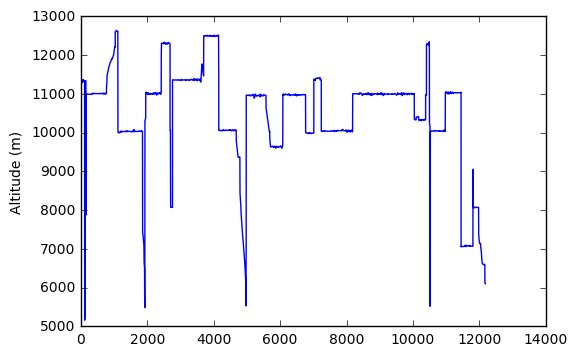

In [10]:
plot(raw['altGPS'][iwc_mean>1.5])
ylabel('Altitude (m)')

### Vertical wind profiles in different MMD categories

In [9]:
# grouped w wind profile by MMD cats
totaln=23
cbindbackward=cbmmd=np.zeros([0,1])
cbalt=cbupdf=np.ndarray([500,0])
for i in range(totaln):
# for i in range(12,17):
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        try:
            ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        except:
            continue
            pass
#         updf=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        if np.prod(ds.w_ret.shape) == 0:
            continue;
        updf = ds.w_ret.where(ds.Mask_Vz==1).values.transpose()
        alt = ds.height_2D.values.transpose()
        if updf.ndim == 1:
            updf=updf[:,np.newaxis]
            alt=alt[:,np.newaxis]
            time=time[np.newaxis,:]
            
        alt = alt-alt[249,:]
        
        cbindbackward=np.concatenate( (cbindbackward,time),axis=0 )
        cbmmd=np.concatenate( (cbmmd,mmd),axis=0 )
        cbupdf=np.concatenate( (cbupdf,updf),axis=1 )
        cbalt=np.concatenate( (cbalt,alt),axis=1 )
#     except:
#         pass

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


In [9]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc',resolution='c',llcrnrlon=110.1,llcrnrlat=-30.1,
            urcrnrlon=150.1,urcrnrlat=5.1)
x,y=m(130,-15)
m.is_land(x,y)

True

In [14]:
# land see masks
totaln=23
cbls=cbindbackward=cbmmd=np.zeros([0,1])
cbls=np.zeros(0,)
cbalt=cbupdf=np.ndarray([500,0])
fltlist = list(range(totaln))
fltlist.remove(12)
fltlist.remove(13)
# for i in fltlist:
for i in range(12,13):
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        lon = raw['lon'][ np.squeeze(proc['indpsdback'][tmp]) ]
        x,y=m(np.squeeze(raw['lon'][ np.squeeze(proc['indpsdback'][tmp]) ]),
              np.squeeze(raw['lat'][ np.squeeze(proc['indpsdback'][tmp]) ]))
        ls=x
        try:
            ttt=len(x)
            for j in range(ttt):
                ls[j]=m.is_land(x[j],y[j])
        except:
            ttt=1
            ls=np.zeros(1,)
            ls[0]=np.array(m.is_land(x,y))
            pass
        
        ### For RASTA data
        try:
            ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        except:
            continue
            pass
#         updf=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        if np.prod(ds.w_ret.shape) == 0:
            continue;
        updf = ds.w_ret.where(ds.Mask_Vz==1).values.transpose()
        alt = ds.height_2D.values.transpose()
        if updf.ndim == 1:
            updf=updf[:,np.newaxis]
            alt=alt[:,np.newaxis]
            time=time[np.newaxis,:]
#             ls=ls[np.newaxis,:]
            
        alt = alt-alt[249,:]
        
        cbindbackward=np.concatenate( (cbindbackward,time),axis=0 )
        cbmmd=np.concatenate( (cbmmd,mmd),axis=0 )
        cbupdf=np.concatenate( (cbupdf,updf),axis=1 )
        cbalt=np.concatenate( (cbalt,alt),axis=1 )
        cbls=np.concatenate( (cbls,ls),axis=0 )
#     except:
#         pass

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


In [13]:
mmdlandpart=cbmmd[cbls==1]
mmdseapart=cbmmd[cbls==0]

In [15]:
mmdlandpart2=cbmmd[cbls==1]
mmdseapart2=cbmmd[cbls==0]

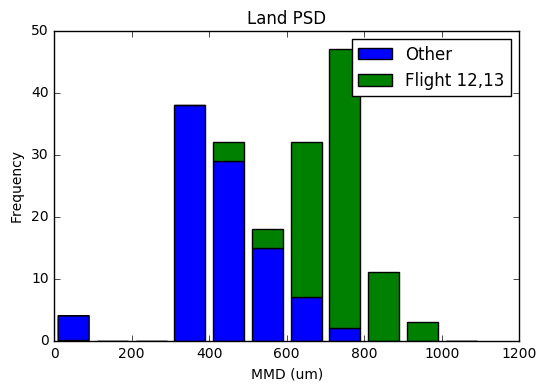

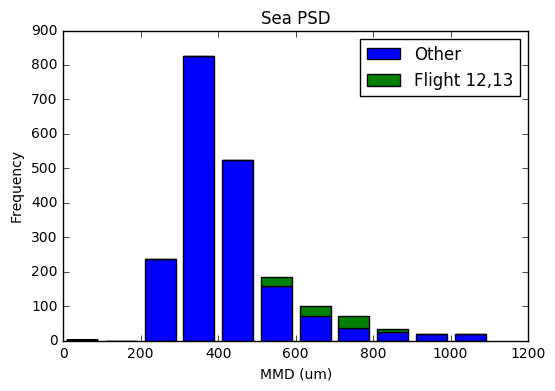

In [23]:
bins = np.arange(0,1200,100)
plt.hist([mmdlandpart,mmdlandpart2],bins=bins,stacked=True,label=['Other','Flight 12,13'])
plt.xlabel('MMD (um)')
plt.ylabel('Frequency')
plt.title('Land PSD')
plt.xlim(0,1200)
plt.legend()
plt.show()
plt.hist([mmdseapart,mmdseapart2],bins=bins,stacked=True,label=['Other','Flight 12,13'])
plt.xlabel('MMD (um)')
plt.ylabel('Frequency')
plt.xlim(0,1200)
plt.title('Sea PSD')
plt.legend()
plt.show()

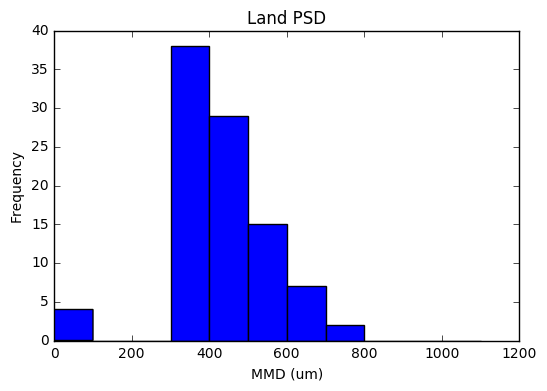

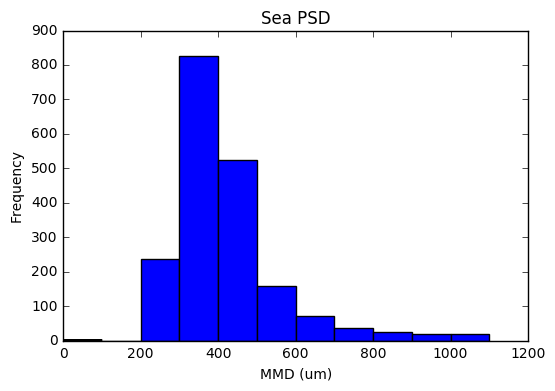

In [12]:
mmdland=cbmmd[cbls==1]
mmdsea=cbmmd[cbls==0]
bins = np.arange(0,1200,100)
plt.hist(mmdland,bins=bins)
plt.xlabel('MMD (um)')
plt.ylabel('Frequency')
plt.title('Land PSD')
plt.xlim(0,1200)
plt.show()
plt.hist(mmdsea,bins=bins)
plt.xlabel('MMD (um)')
plt.ylabel('Frequency')
plt.xlim(0,1200)
plt.title('Sea PSD')
plt.show()

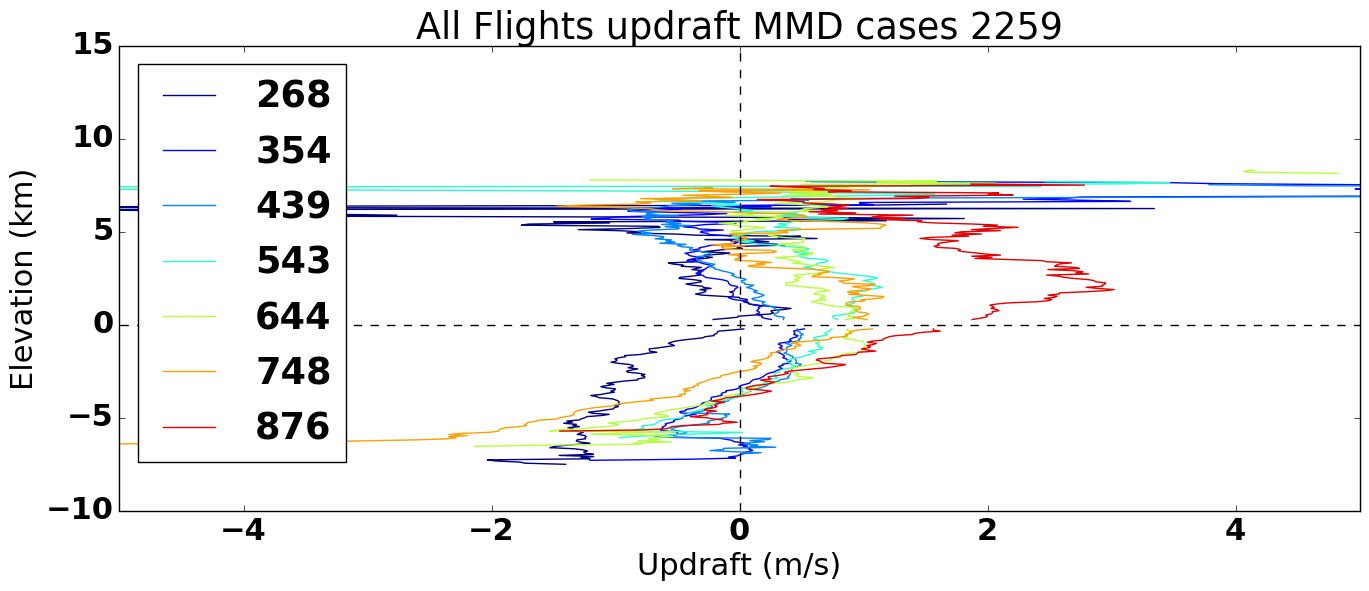

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## PREVIOUS CELL REQUIRED
fig=figure(figsize=[16,6])
mmdbins = np.array([0,200,300,400,500,600,700,800,1000])
mmdind = np.digitize(cbmmd,mmdbins)

colormapping=mpl.cm.ScalarMappable(norm=None,cmap='jet')
colors=colormapping.to_rgba(mmdbins[1:-1])

# tmpc=np.array(['r','g','b','k'])
tmpmmd=np.zeros(len(mmdbins))
for j in range(1,len(mmdbins)-1):## skip the first bin (mmd<200)
    tmpind=np.in1d(mmdind,j+1)
    x1=cbupdf[:,tmpind]
    y1=cbalt[:,tmpind]
    x0=np.nanmean(x1,axis=1)
    y0=np.nanmean(y1,axis=1)
    tmpmmd[j]=np.nanmean(cbmmd[tmpind])
    plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
#     plot(x0,y0)

ax=plt.gca()
ax.legend(tmpmmd[1:-1].astype(int).astype(str),loc='best')
plt.ylabel('Elevation (km)')
plt.xlabel('Updraft (m/s)')
plt.xlim(-5,5)
plt.title('All Flights updraft MMD cases '+str(len(np.squeeze(cbmmd))))
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.show()

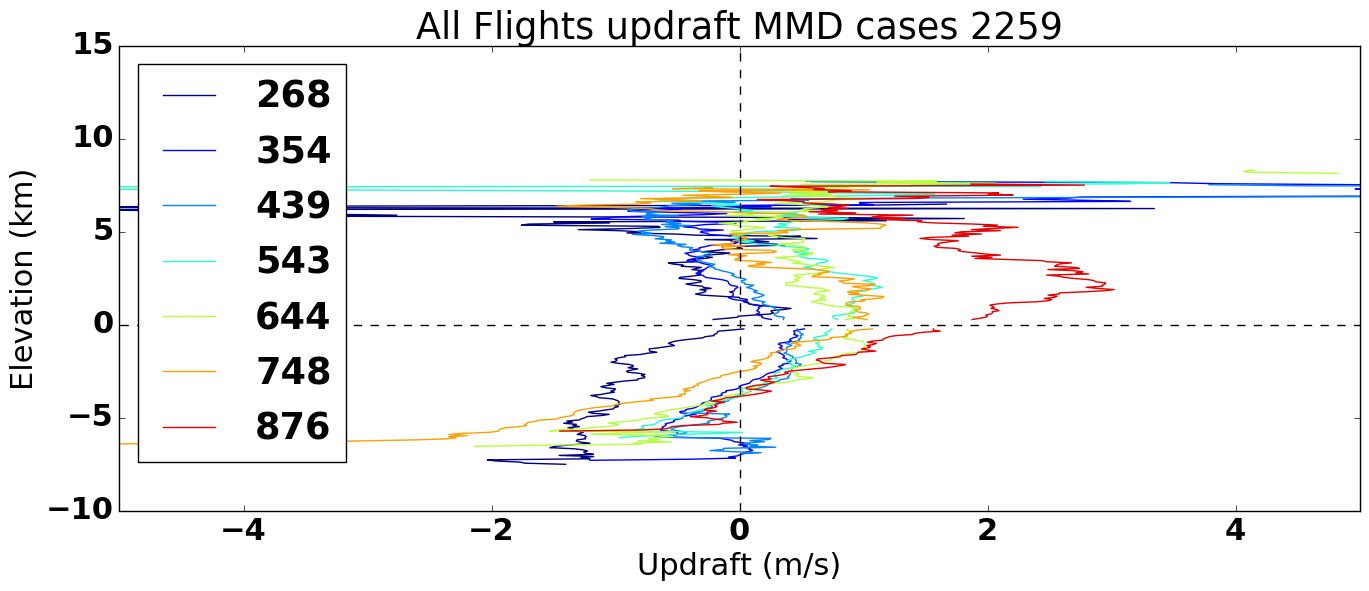

In [12]:
### land see masks
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## PREVIOUS CELL REQUIRED
fig=figure(figsize=[16,6])
mmdbins = np.array([0,200,300,400,500,600,700,800,1000])
mmdind = np.digitize(cbmmd,mmdbins)

colormapping=mpl.cm.ScalarMappable(norm=None,cmap='jet')
colors=colormapping.to_rgba(mmdbins[1:-1])

# tmpc=np.array(['r','g','b','k'])
tmpmmd=np.zeros(len(mmdbins))
for j in range(1,len(mmdbins)-1):## skip the first bin (mmd<200)
    tmpind=np.in1d(mmdind,j+1)
    x1=cbupdf[:,tmpind]
    y1=cbalt[:,tmpind]
    x0=np.nanmean(x1,axis=1)
    y0=np.nanmean(y1,axis=1)
    tmpmmd[j]=np.nanmean(cbmmd[tmpind])
    plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
#     plot(x0,y0)

ax=plt.gca()
ax.legend(tmpmmd[1:-1].astype(int).astype(str),loc='best')
plt.ylabel('Elevation (km)')
plt.xlabel('Updraft (m/s)')
plt.xlim(-5,5)
plt.title('All Flights updraft MMD cases '+str(len(np.squeeze(cbmmd))))
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.show()

/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


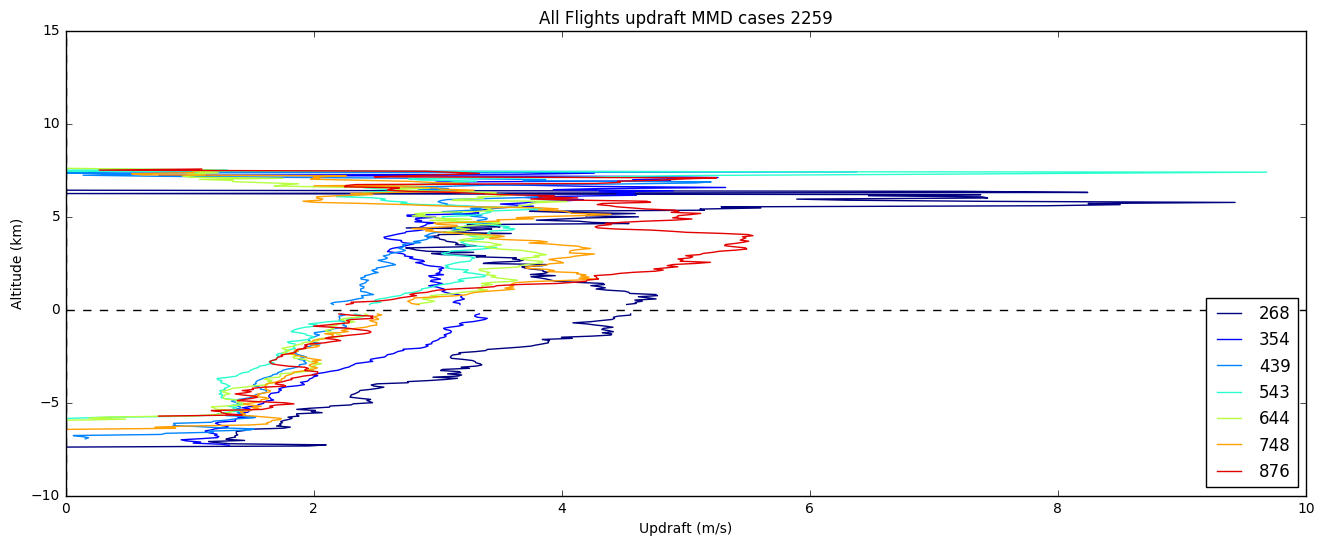

In [13]:
## PREVIOUS CELL REQUIRED
fig=figure(figsize=[16,6])
mmdbins = np.array([0,200,300,400,500,600,700,800,1000])
mmdind = np.digitize(cbmmd,mmdbins)

colormapping=mpl.cm.ScalarMappable(norm=None,cmap='jet')
colors=colormapping.to_rgba(mmdbins[1:-1])

# tmpc=np.array(['r','g','b','k'])
tmpmmd=np.zeros(len(mmdbins))
for j in range(1,len(mmdbins)-1):## skip the first bin (mmd<200)
    tmpind=np.in1d(mmdind,j+1)
    x1=cbupdf[:,tmpind]
    y1=cbalt[:,tmpind]
    x0=np.nanstd(x1,axis=1)
    y0=np.nanmean(y1,axis=1)
    tmpmmd[j]=np.nanmean(cbmmd[tmpind])
    plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
#     plot(x0,y0)

ax=plt.gca()
ax.legend(tmpmmd[1:-1].astype(int).astype(str),loc='best')
plt.ylabel('Altitude (km)')
plt.xlabel('Updraft (m/s)')
plt.title('All Flights updraft MMD cases '+str(len(np.squeeze(cbmmd))))
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.show()

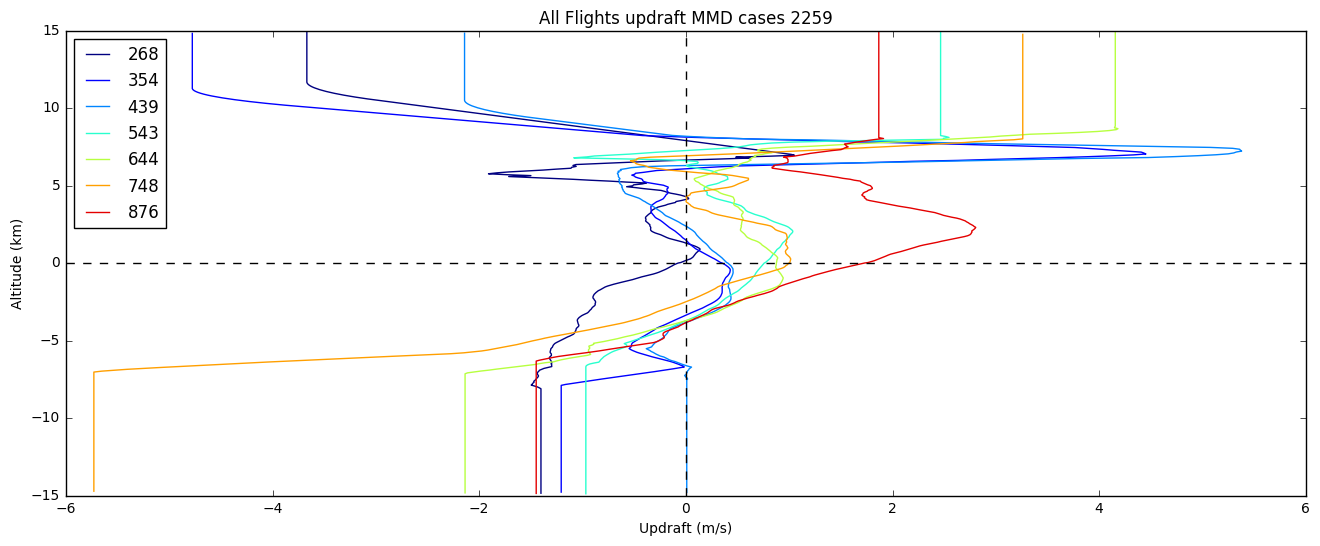

In [14]:
## PREVIOUS CELL REQUIRED
from scipy import signal
def moving_average(a, n=3) :
    hlf = int(n/2.)
    n = hlf*2+1
    ret = np.cumsum(a, dtype=float)
    ret[hlf:-hlf]=(ret[n-1:]-ret[:-n+1])/(n-1)
    return np.concatenate((a[:hlf],ret[hlf:-hlf],a[-hlf:]))

def fill_nan(x0):
    ########### Interesting code to interpolate the NaN's
    nans, x= np.isnan(x0), lambda z: z.nonzero()[0]
    x0[nans]= np.interp(x(nans), x(~nans), x0[~nans])
    return x0

fig=figure(figsize=[16,6])
mmdbins = np.array([0,200,300,400,500,600,700,800,1000])
mmdind = np.digitize(cbmmd,mmdbins)

colormapping=mpl.cm.ScalarMappable(norm=None,cmap='jet')
colors=colormapping.to_rgba(mmdbins[1:-1])

# tmpc=np.array(['r','g','b','k'])
tmpmmd=np.zeros(len(mmdbins))
for j in range(1,len(mmdbins)-1):## skip the first bin (mmd<200)
    tmpind=np.in1d(mmdind,j+1)
    x1=cbupdf[:,tmpind]
    y1=cbalt[:,tmpind]
    y0=np.nanmean(y1,axis=1)
    x0=np.nanmean(x1,axis=1)
    
    x0=fill_nan(x0)
    x0=moving_average(x0,n=20)
#     x0=np.diff(x0)
    tmpmmd[j]=np.nanmean(cbmmd[tmpind])
    plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
#     plot(x0,y0)

ax=plt.gca()
ax.legend(tmpmmd[1:-1].astype(int).astype(str),loc='best')
plt.ylabel('Altitude (km)')
plt.xlabel('Updraft (m/s)')
# plt.xlim(-.5,.5)
plt.title('All Flights updraft MMD cases '+str(len(np.squeeze(cbmmd))))
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.show()

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


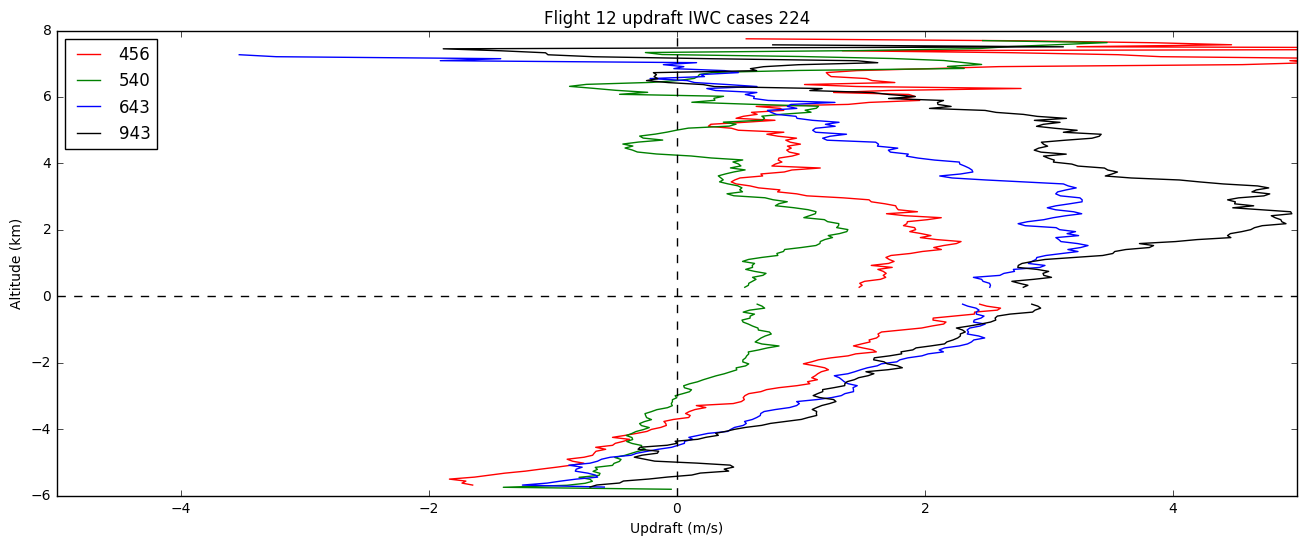

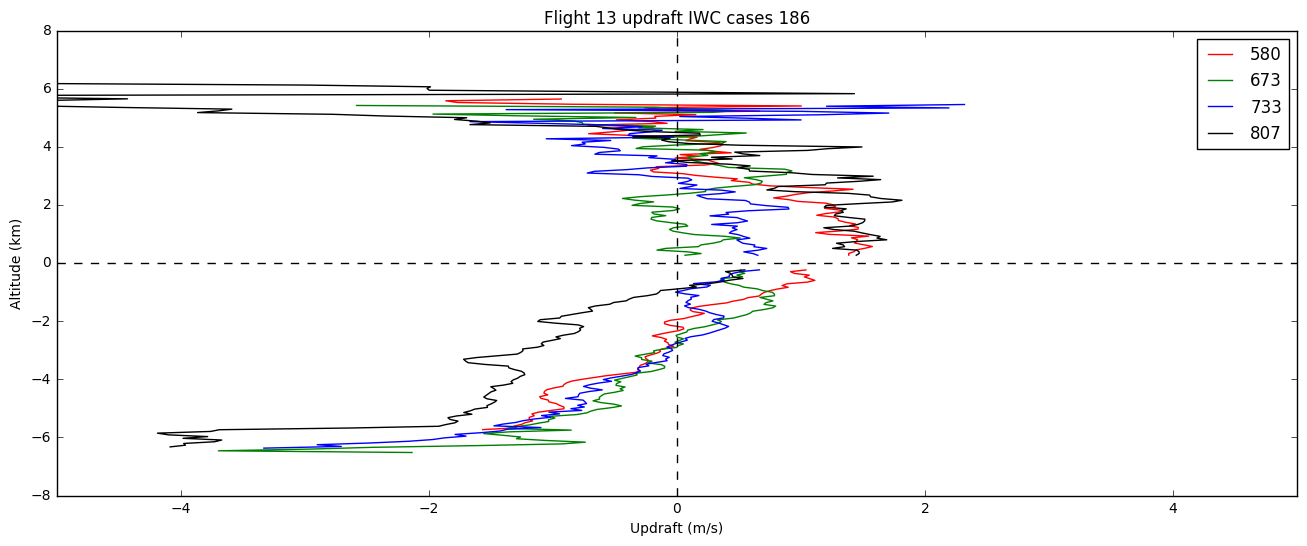

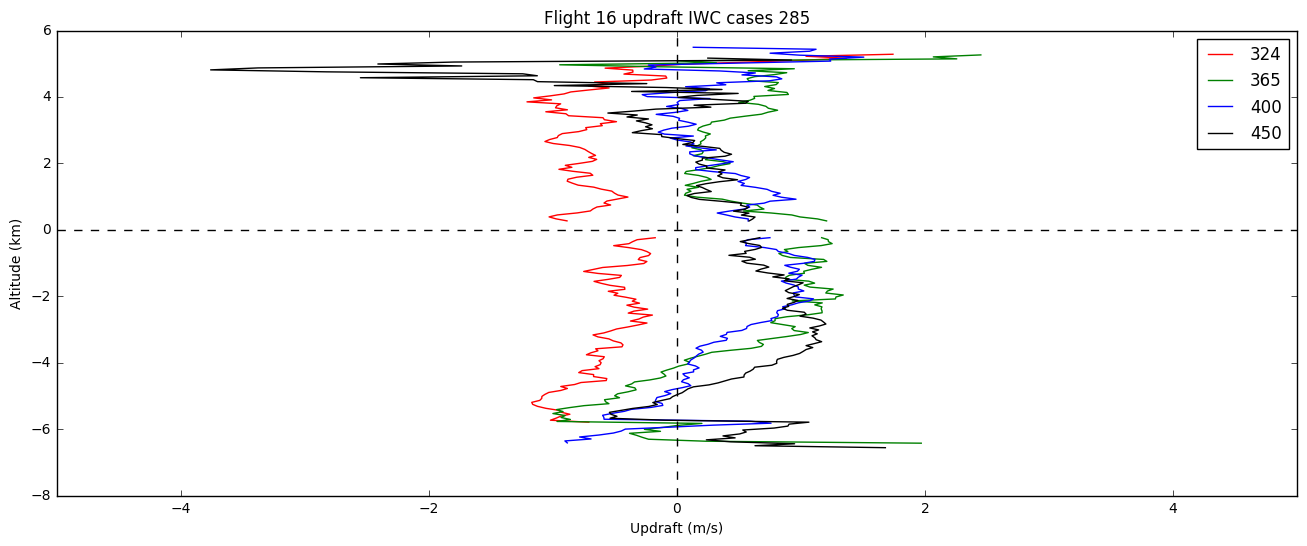

In [5]:
# grouped w wind profile by MMD cats
totaln=23
cbindbackward=cbmmd=np.zeros([0,1])
cbalt=cbupdf=np.ndarray([500,0])
# for i in range(totaln):
for i in [11,12,15]:
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        try:
            ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        except:
            continue
            pass
#         updf=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        if np.prod(ds.w_ret.shape) == 0:
            continue;
        updf = ds.w_ret.where(ds.Mask_Vz==1).values.transpose()
        alt = ds.height_2D.values.transpose()
        if updf.ndim == 1:
            updf=updf[:,np.newaxis]
            alt=alt[:,np.newaxis]
            time=time[np.newaxis,:]
            
        alt = alt-alt[249,:]
        
        fig=figure(figsize=[16,6])
        mmdbins = np.percentile(mmd, np.arange(0,100.1,25))
        mmdind = np.digitize(mmd,mmdbins)

        tmpc=np.array(['r','g','b','k'])
        tmpmmd=np.zeros(len(mmdbins)-1)
        for j in range(1,len(mmdbins)):
            tmpind=np.in1d(mmdind,j)
            x1=updf[:,tmpind]
            y1=alt[:,tmpind]
            x0=np.nanmean(x1,axis=1)
            y0=np.nanmean(y1,axis=1)
            tmpmmd[j-1]=np.nanmean(mmd[tmpind])
        #             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
            plot(x0,y0,c=tmpc[j-1])

        ax=plt.gca()
        ax.legend(tmpmmd.astype(int).astype(str),loc='best')
        plt.ylabel('Altitude (km)')
        plt.xlabel('Updraft (m/s)')
        plt.xlim(-5,5)
        plt.title('Flight '+str(szi)+' updraft IWC cases '+str(len(mmd)))
        plt.plot(plt.xlim(),np.array([0,0]),'k--')
        plt.plot(np.array([0,0]),plt.ylim(),'k--')
        plt.show()

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


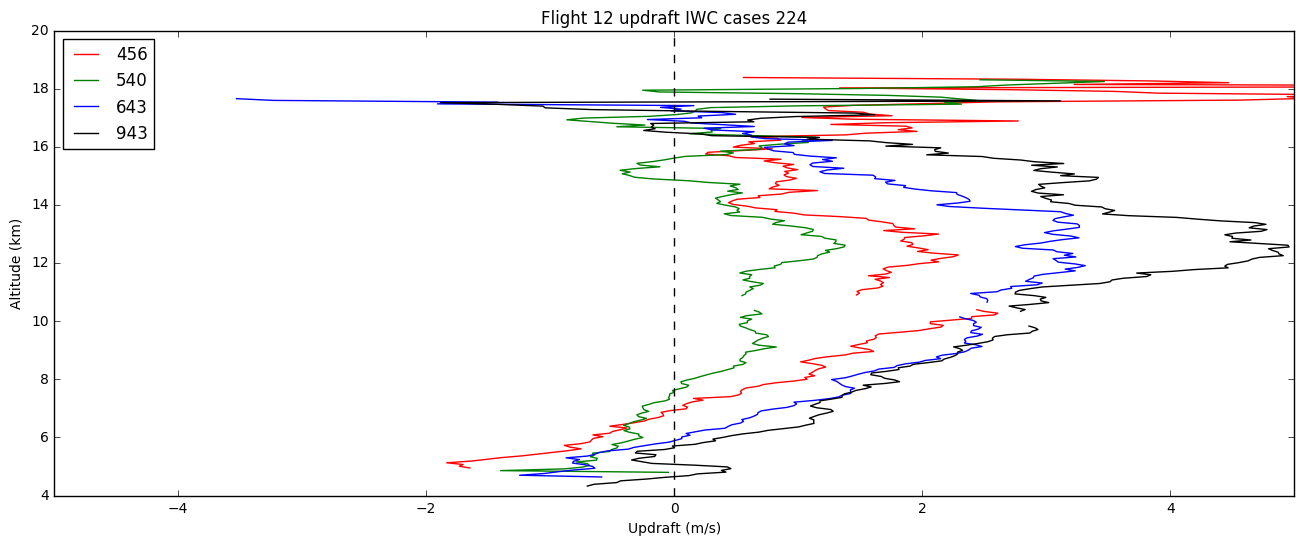

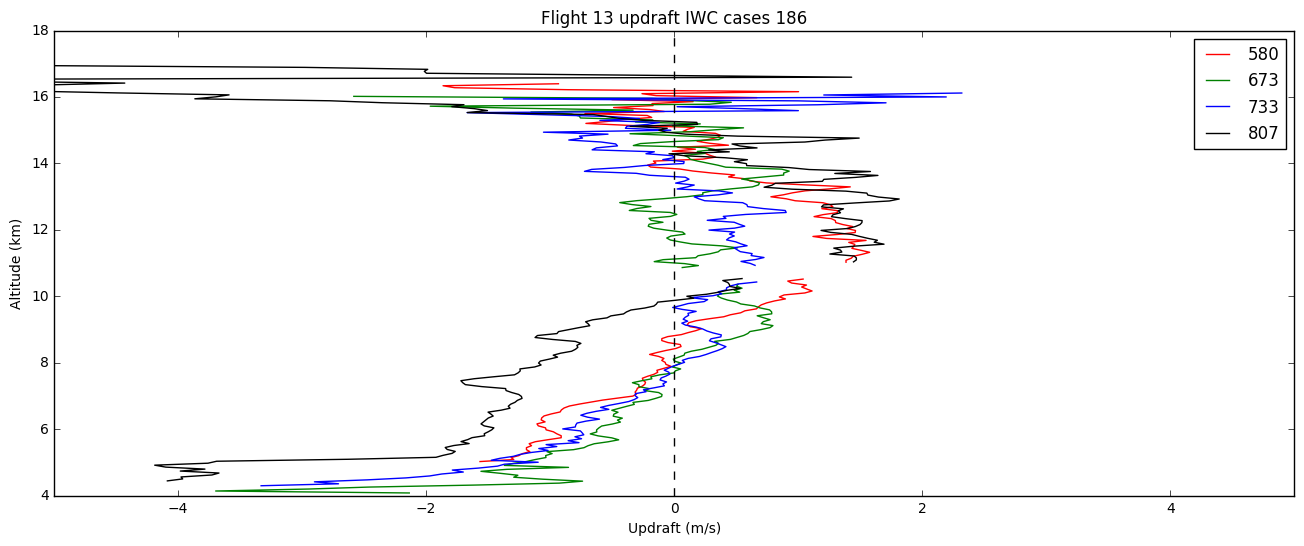

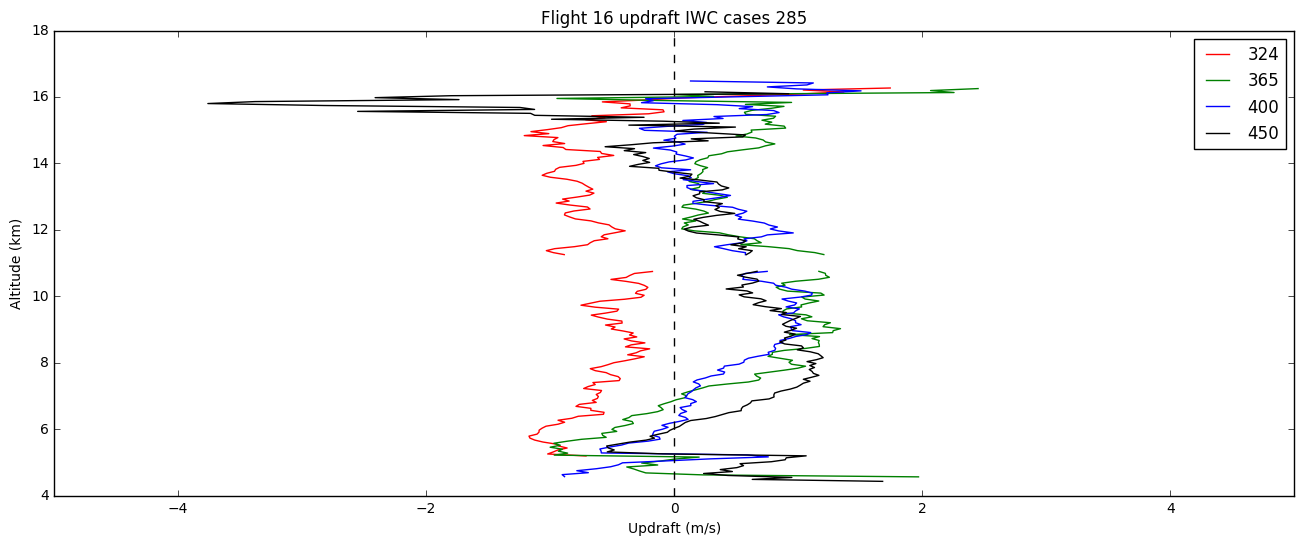

In [8]:
# grouped w wind profile by MMD cats
totaln=23
cbindbackward=cbmmd=np.zeros([0,1])
cbalt=cbupdf=np.ndarray([500,0])
# for i in range(totaln):
for i in [11,12,15]:
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        try:
            ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        except:
            continue
            pass
#         updf=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        if np.prod(ds.w_ret.shape) == 0:
            continue;
        updf = ds.w_ret.where(ds.Mask_Vz==1).values.transpose()
        alt = ds.height_2D.values.transpose()
        if updf.ndim == 1:
            updf=updf[:,np.newaxis]
            alt=alt[:,np.newaxis]
            time=time[np.newaxis,:]
            
#         alt = alt-alt[249,:]
        
        fig=figure(figsize=[16,6])
        mmdbins = np.percentile(mmd, np.arange(0,100.1,25))
        mmdind = np.digitize(mmd,mmdbins)

        tmpc=np.array(['r','g','b','k'])
        tmpmmd=np.zeros(len(mmdbins)-1)
        for j in range(1,len(mmdbins)):
            tmpind=np.in1d(mmdind,j)
            x1=updf[:,tmpind]
            y1=alt[:,tmpind]
            x0=np.nanmean(x1,axis=1)
            y0=np.nanmean(y1,axis=1)
            tmpmmd[j-1]=np.nanmean(mmd[tmpind])
        #             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
            plot(x0,y0,c=tmpc[j-1])

        ax=plt.gca()
        ax.legend(tmpmmd.astype(int).astype(str),loc='best')
        plt.ylabel('Altitude (km)')
        plt.xlabel('Updraft (m/s)')
        plt.xlim(-5,5)
        plt.title('Flight '+str(szi)+' updraft IWC cases '+str(len(mmd)))
#         plt.plot(plt.xlim(),np.array([0,0])+12,'k--')
        plt.plot(np.array([0,0]),plt.ylim(),'k--')
        plt.show()

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


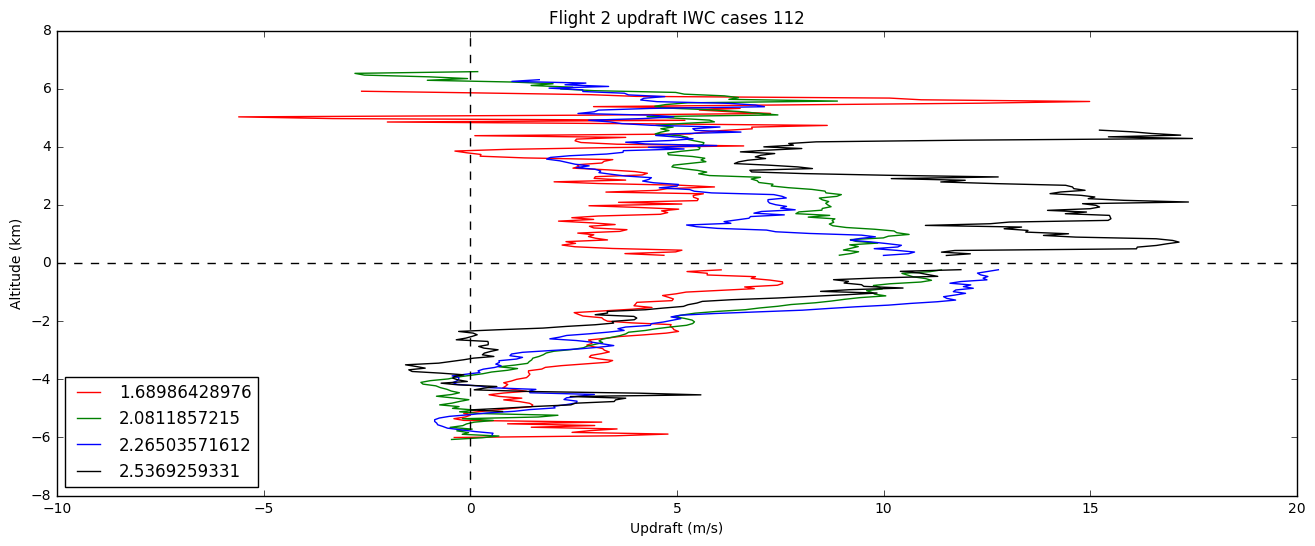

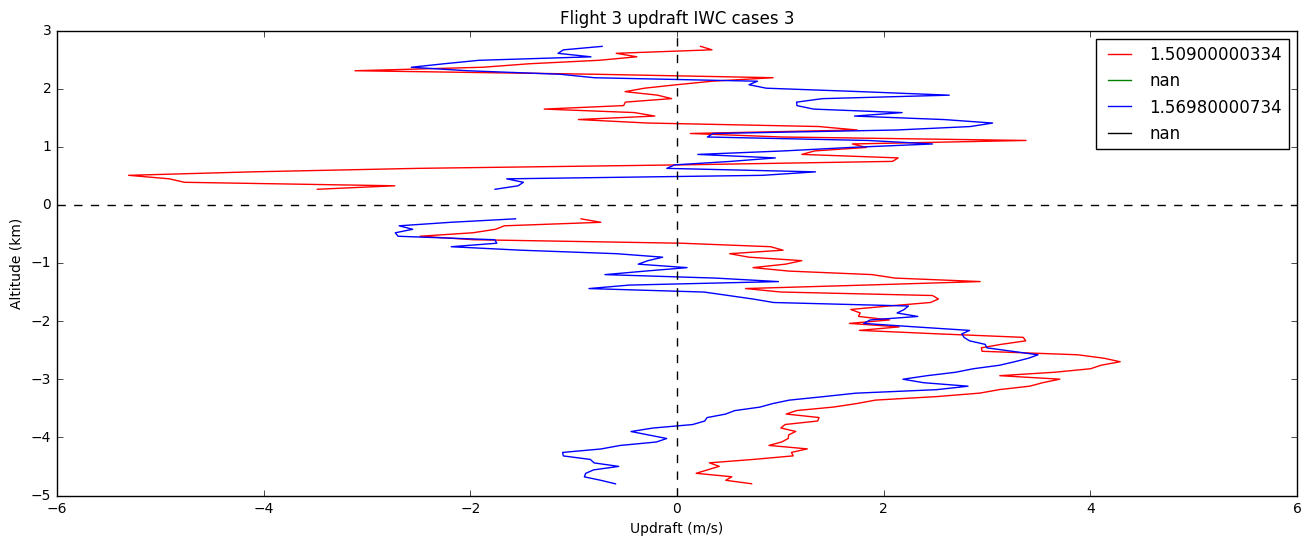

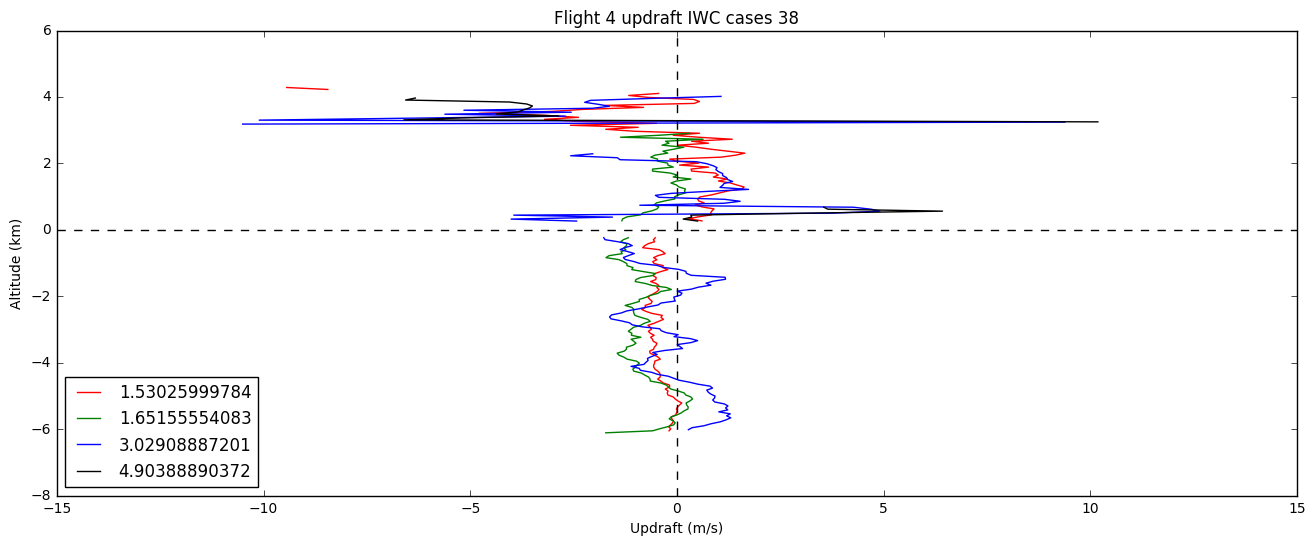

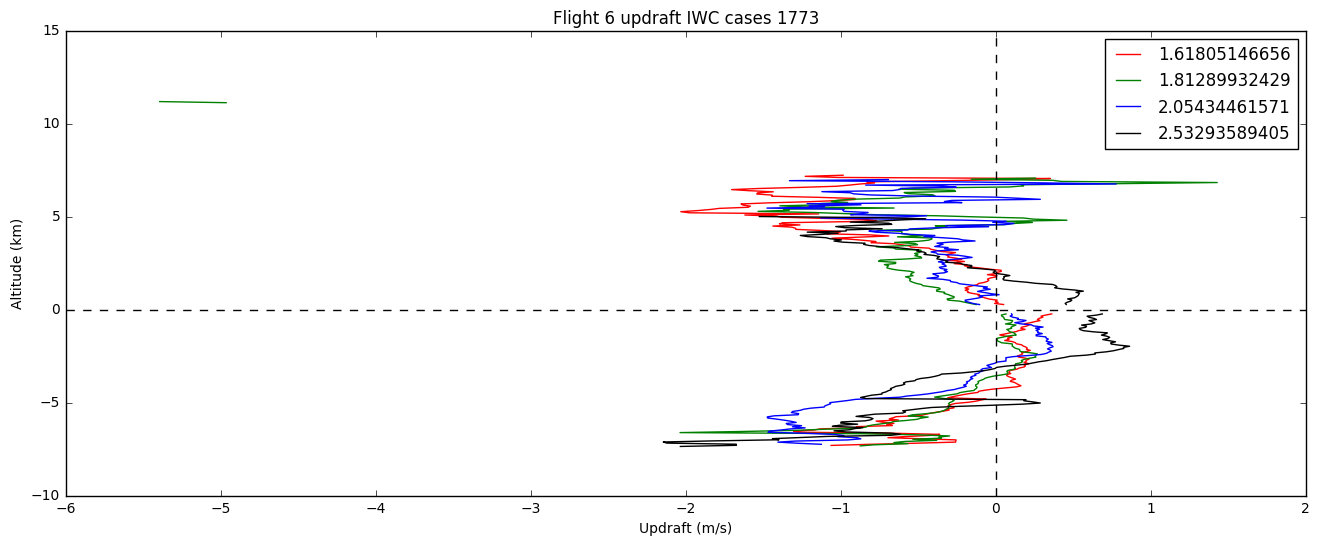

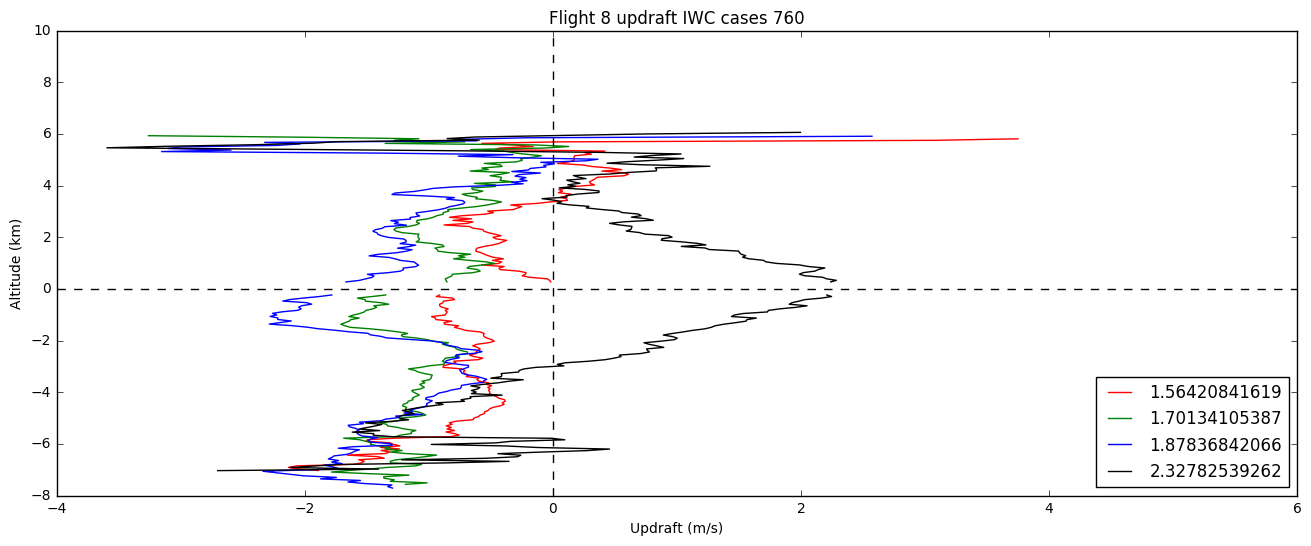

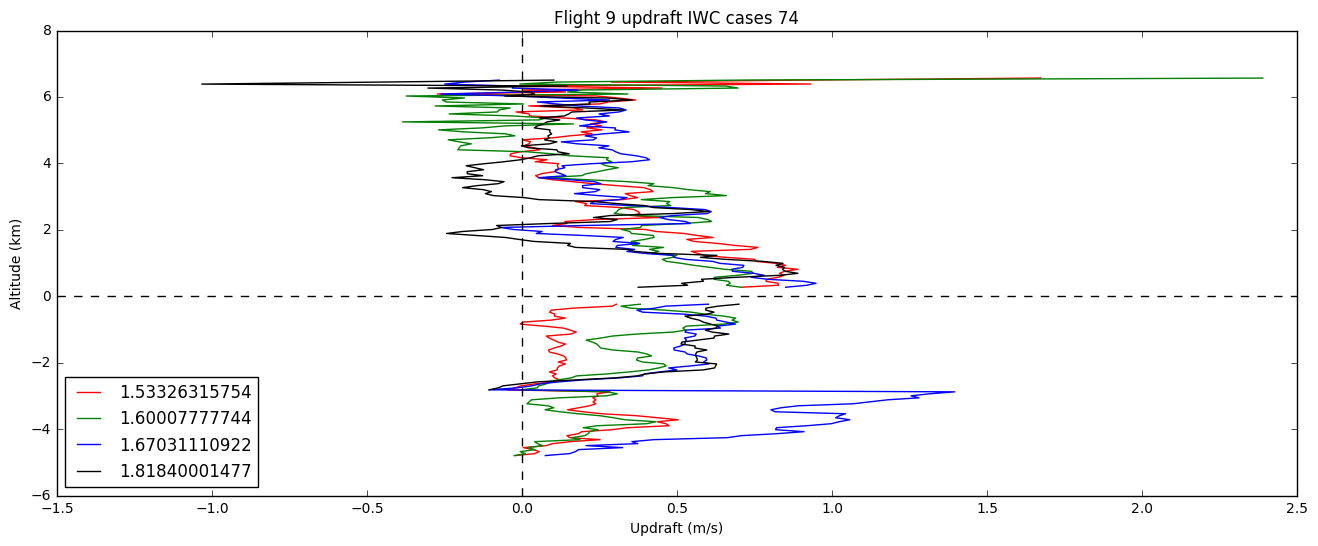

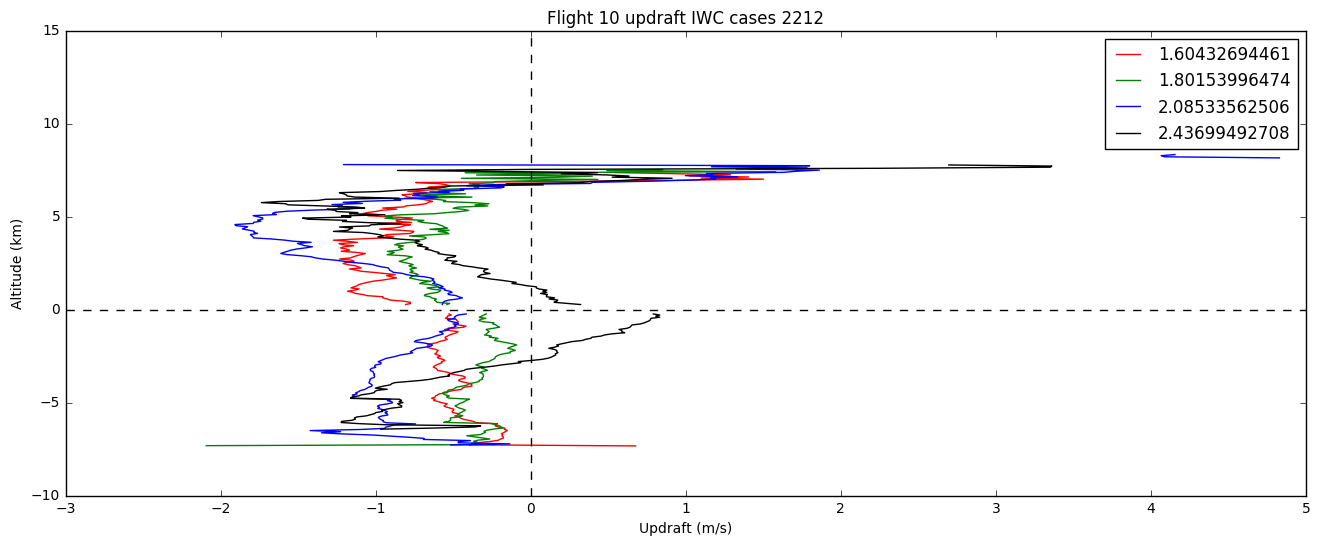

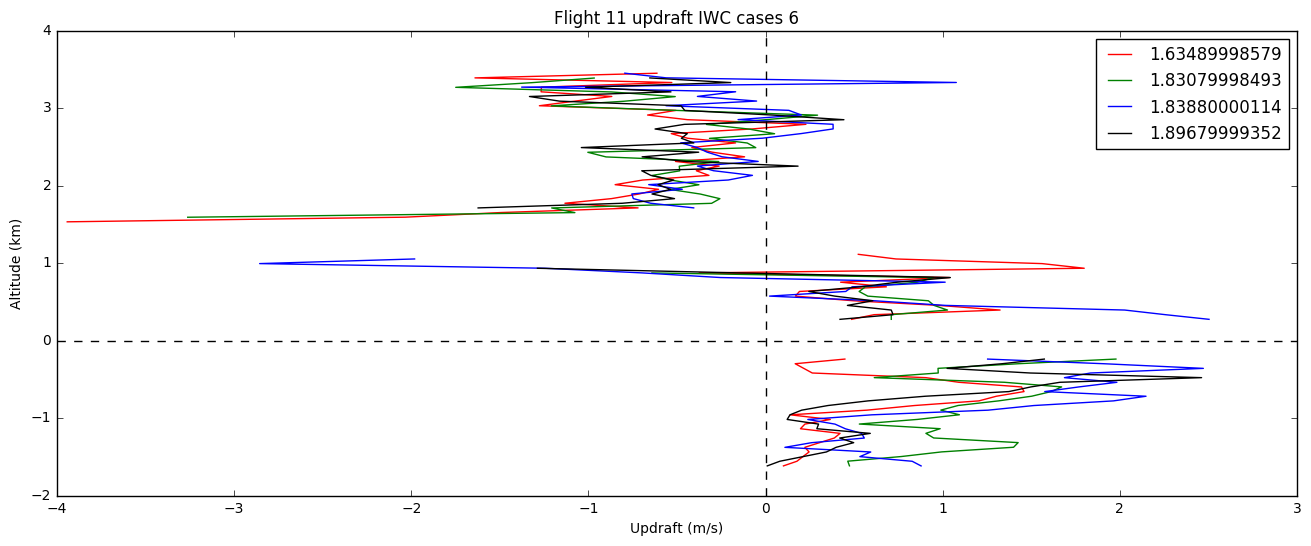

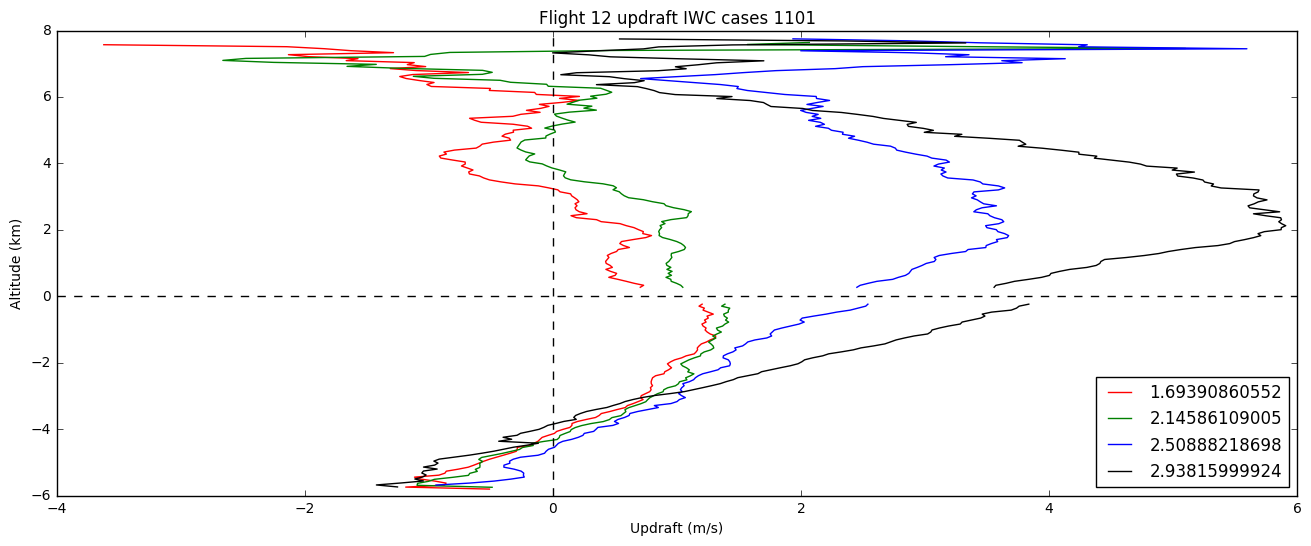

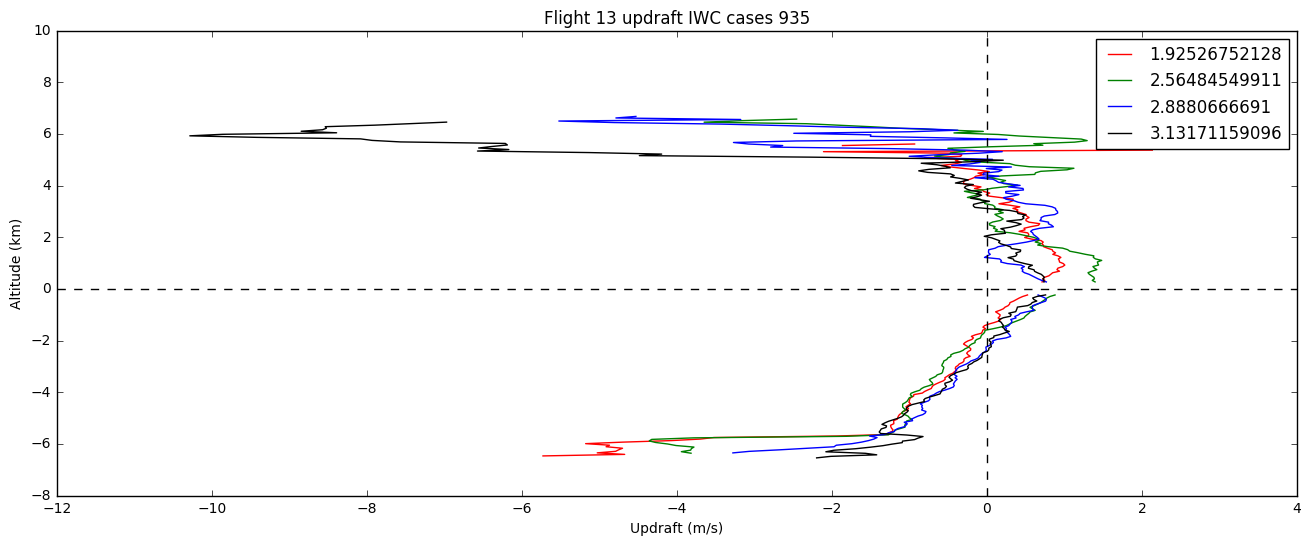

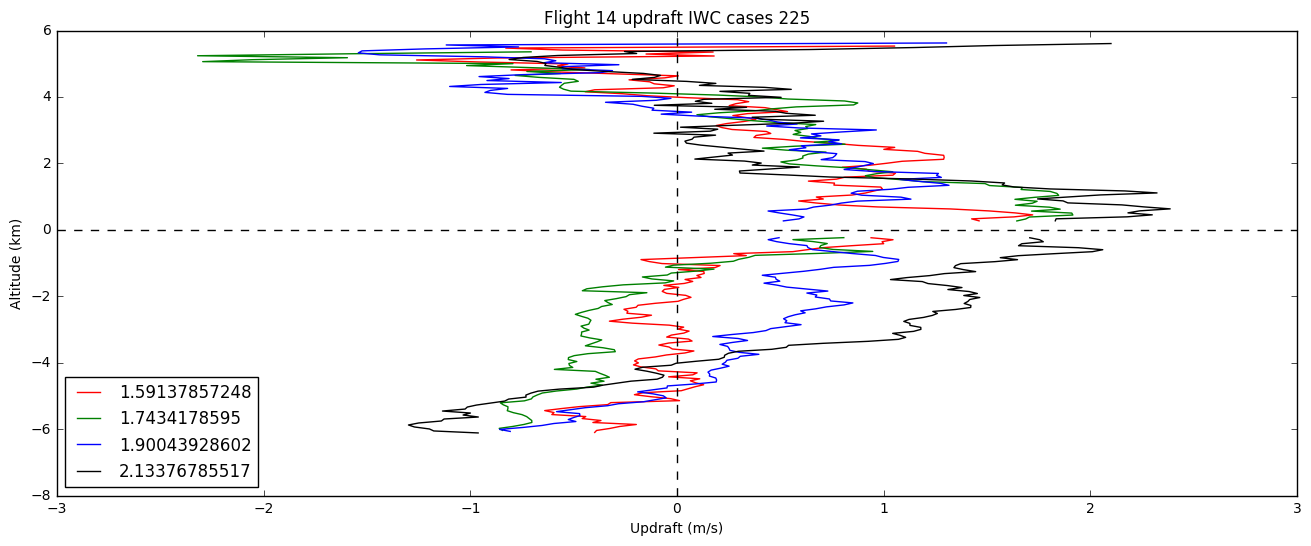

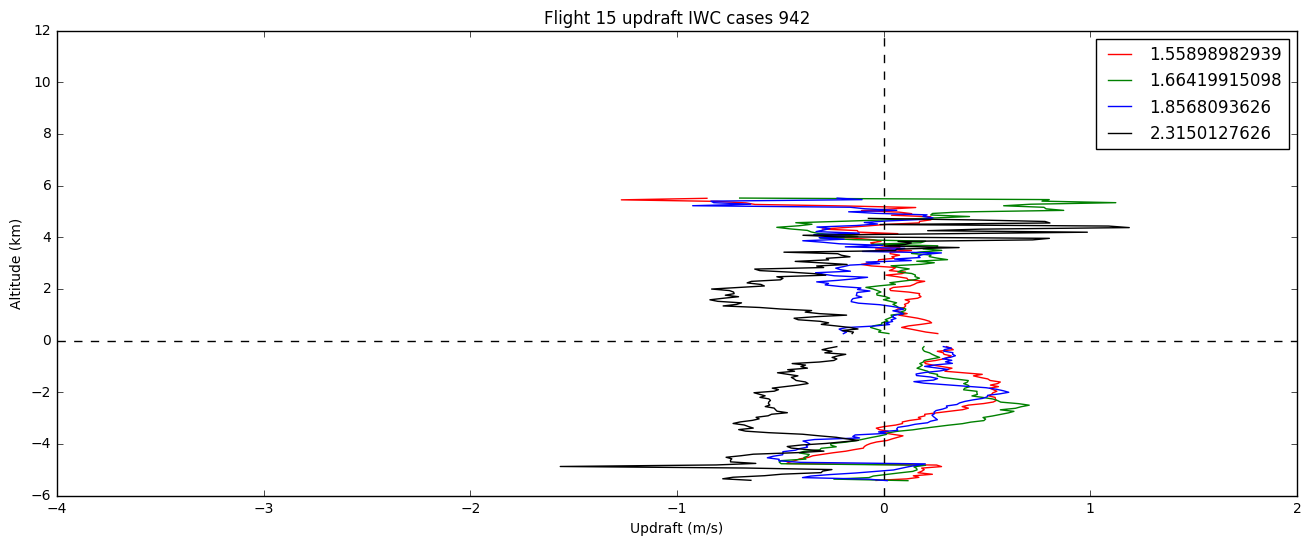

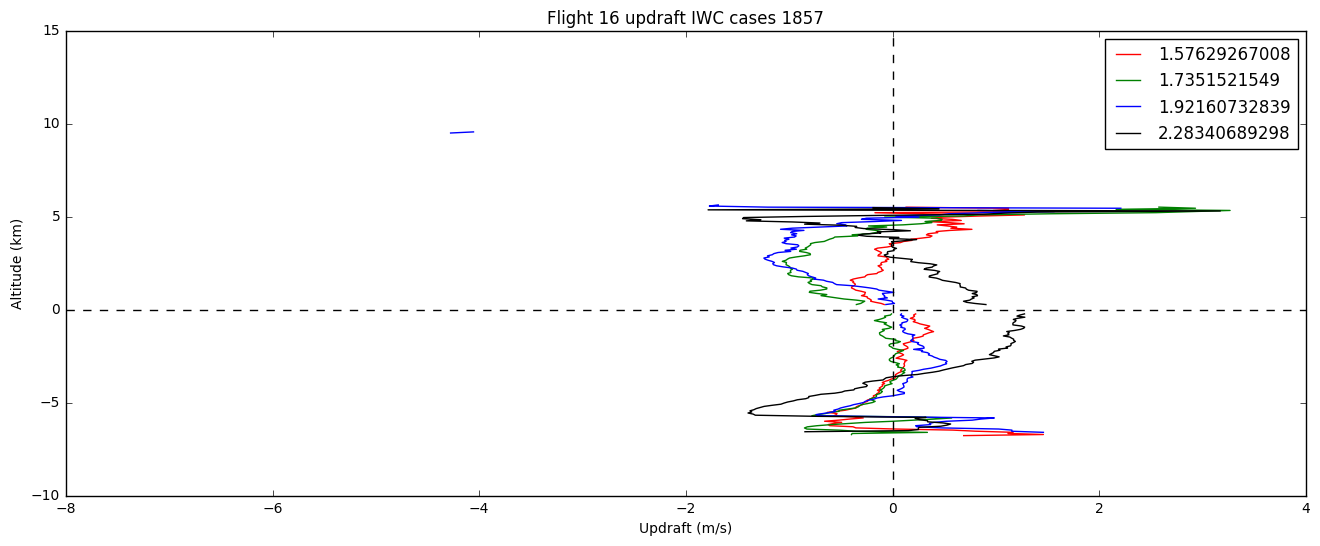

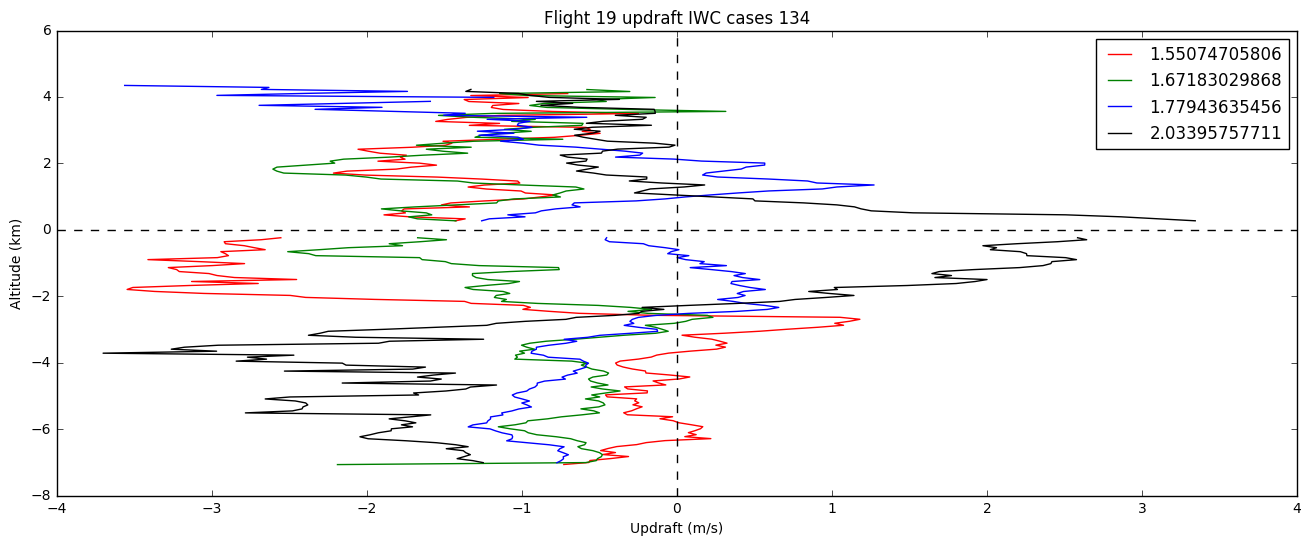

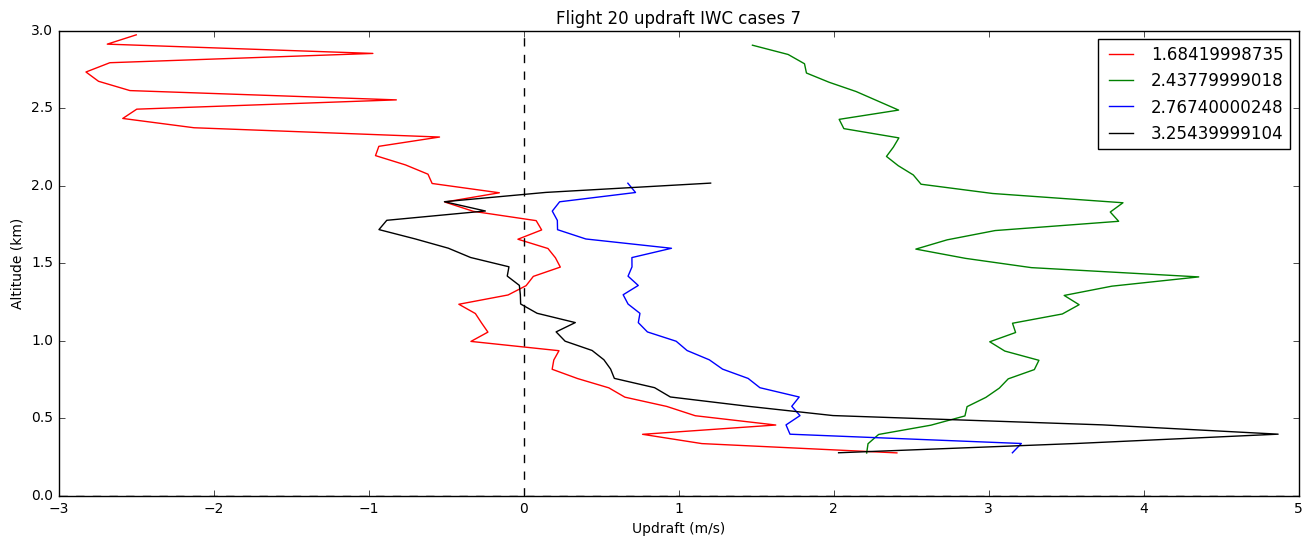

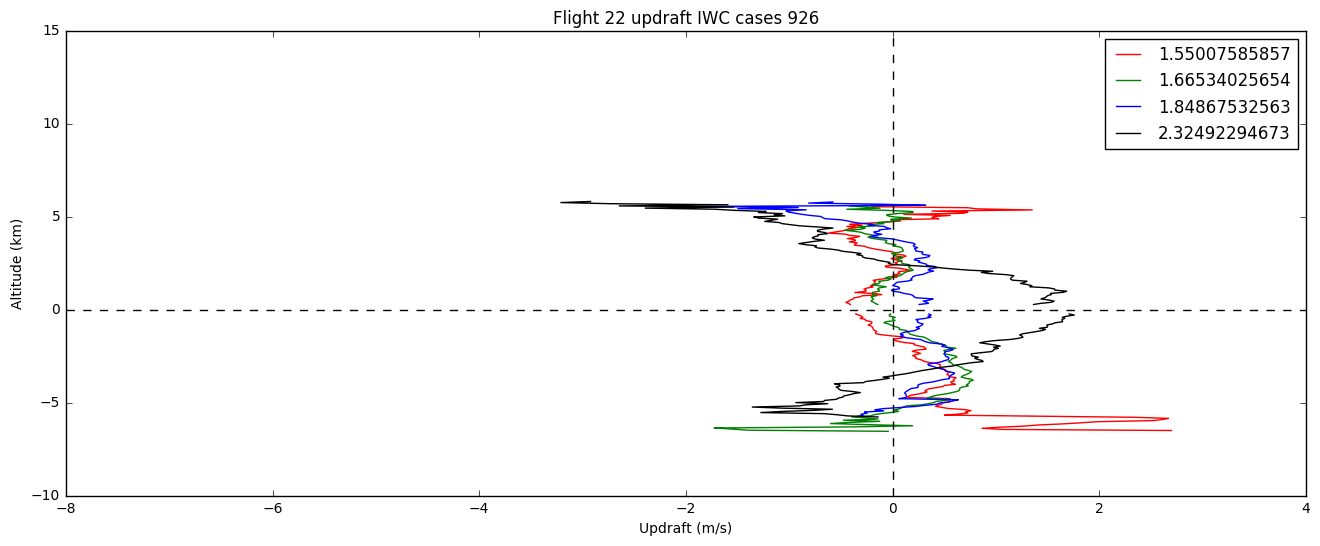

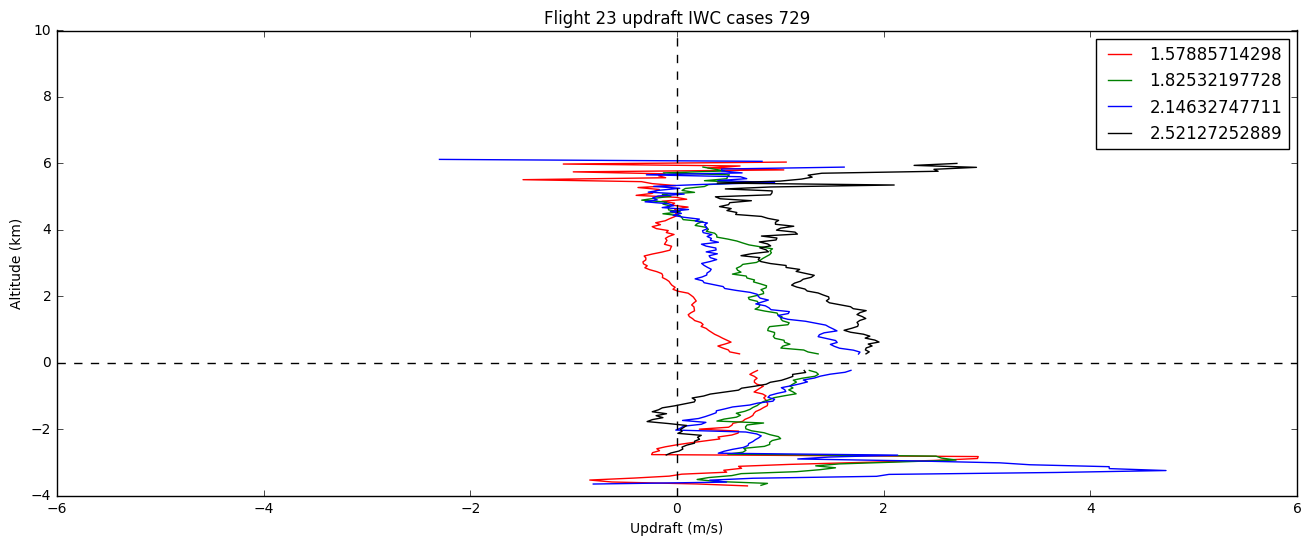

In [16]:
# grouped w wind profile by IWC cats
import pandas as pd


totaln=23
for i in range(totaln):
# for i in range(12,13):
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        
        ### For PSD data
        indflt=((raw['flightnum']==szi) & (iwc_mean>1.5))
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = iwc_mean[ indflt ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ indflt ]
        
        ### For RASTA data
        ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
#         updf=ds.w_ret.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        updf = ds.w_ret.where(ds.Mask_Vz==1)
        
        mmdbins = np.percentile(mmd, np.arange(0,100.1,25))
        mmdind = np.digitize(mmd,mmdbins)
        colormapping=mpl.cm.ScalarMappable(norm=None, cmap='jet')
        colors=colormapping.to_rgba(mmdbins[:-1]+np.diff(mmdbins))
        
        tmpc=np.array(['r','g','b','k'])
        tmpmmd=np.zeros(len(mmdbins)-1)
        for j in range(1,len(mmdbins)):
            tmpind=np.in1d(mmdind,j)
            x1=updf.values[tmpind,:].transpose()
            tmp=ds.height_2D.values
            y1=(tmp[tmpind,:]-tmp[tmpind,249][:,np.newaxis]).transpose()
            x0=np.nanmean(x1,axis=1)
            y0=np.nanmean(y1,axis=1)
            tmpmmd[j-1]=np.nanmean(mmd[tmpind])
#             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
            plot(x0,y0,c=tmpc[j-1])
            
        ax=plt.gca()
        ax.legend(tmpmmd.astype(str),loc='best')
        plt.ylabel('Altitude (km)')
        plt.xlabel('Updraft (m/s)')
        plt.title('Flight '+str(szi)+' updraft IWC cases '+str(len(np.squeeze(mmd))))
        plt.plot(plt.xlim(),np.array([0,0]),'k--')
        plt.plot(np.array([0,0]),plt.ylim(),'k--')
        plt.show()
    except:
        pass